# Plot optimal window

In [1]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from math import log10, floor
from scipy.optimize import curve_fit

sys.path.append('../modules')
import plot_optimal_window as plt_ow
import estimate_optimal_window as eow

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
%matplotlib inline

## Global variables

In [3]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-04-11"

In [4]:
# Stock indexes
list_stock_indexes = {
    "^GSPC" : "Standard and Poor's 500", # S&P 500 (United States)
    "^DJI" : "Dow Jones Industrial Average", # Dow Jones Industrial Average (United States)
    "^W5000" : "Wilshire 5000", # Wilshire 5000 (United States)
    "^GSPTSE" : "Toronto Stock Exchange Composite index", # S&P/TSX Composite index (Canada)
    "^GDAXI" : "German Stock index", # DAX Performance index (Germany)
    "^FTSE" : "Financial Times Stock Exchange 100", # FTSE 100 (United Kingdom)
    "^FCHI" : "Continuous Assisted Quotation 40", # CAC 40 (France)
    "^IXIC" : "National Association of Securities Dealers Automated Quotation Composite", # NASDAQ Composite (United States)
    "IMOEX.ME" : "Moscow Stock Exchange", # MOEX Russia Index (Russia)
    "^N225" : "Nikkei Heikin Kabuka Stock Exchange 225", # Nikkei 225 (Japan)
    "^STI" : "Straits Times Index 30", # STI Index (Singapore)
    "^BVSP" : "Sao Paulo Stock Exchange", # IBOVESPA (Brazil)
    "^MERV" : "Buenos Aires Stock Exchange" # MERVAL (Argentine)
}

In [5]:
# Currencies
list_currencies = {
    "KWDUSD=X" : "Currency exchange rate from Kuwaiti Dinar to U.S. dollar", # KWD/USD
    "BHDUSD=X" : "Currency exchange rate from Bahraini Dinar to U.S. dollar", # BHD/USD
    "OMRUSD=X" : "Currency exchange rate from Omani Rial to U.S. dollar", # OMR/USD    
    "JODUSD=X" : "Currency exchange rate from Jordanian Dinar to U.S. dollar", # JOD/USD
    "KYDUSD=X" : "Currency exchange rate from Cayman Islands dollar to U.S. dollar", # KYD/USD
    "GBPUSD=X" : "Currency exchange rate from U.K. pound sterling to U.S. dollar", # GBP/USD
    "CHFUSD=X" : "Currency exchange rate from swiss franc to U.S. dollar", # CHF/USD
    "EURUSD=X" : "Currency exchange rate from euro to U.S. dollar", # EUR/USD
    "SGD=X" : "Currency exchange rate from U.S. dollar to Singapore dollar", # USD/SGD
    "CAD=X" : "Currency exchange rate from U.S. dollar to Canadian dollar", # USD/CAD
    "AUD=X" : "Currency exchange rate from U.S. dollar to Australian dollar", # USD/AUD
    "NZD=X" : "Currency exchange rate from U.S. dollar to New Zealand dollar", # USD/NZD
    "MYR=X" : "Currency exchange rate from U.S. dollar to malaysian ringgit", # USD/MYR    
    "BRL=X" : "Currency exchange rate from U.S. dollar to Brazilian real", # USD/BRL    
    "CNY=X" : "Currency exchange rate from U.S. dollar to chinese renminbi", # USD/CNY
    "HKD=X" : "Currency exchange rate from U.S. dollar to Hong Kong dollar", # USD/HKD
    "SEK=X" : "Currency exchange rate from U.S. dollar to swedish krona", # USD/SEK
    "ZAR=X" : "Currency exchange rate from U.S. dollar to South African rand", # USD/ZAR
    "MXN=X" : "Currency exchange rate from U.S. dollar to mexican peso", # USD/MXN
    "THB=X" : "Currency exchange rate from U.S. dollar to thai baht", # USD/THB
    "PHP=X" : "Currency exchange rate from U.S. dollar to philippines peso", # USD/PHP
    "RUB=X" : "Currency exchange rate from U.S. dollar to russian ruble", # USD/RUB
    "INR=X" : "Currency exchange rate from U.S. dollar to indian rupee", # USD/INR
    "JPY=X" : "Currency exchange rate from U.S. dollar to japanese yen", # USD/JPY    
    "HUF=X" : "Currency exchange rate from U.S. dollar to hungarian forints", # USD/HUF
    "COP=X" : "Currency exchange rate from U.S. dollar to colombian peso", # USD/COP
    "IDR=X" : "Currency exchange rate from U.S. dollar to indonesian rupiah", # USD/IDR
    "EURCOP=X" : "Currency exchange rate from euro to colombian peso" # EUR/COP
}

## Load time series

In [6]:
df_stock_indexes = pd.read_csv("{}/df_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies = pd.read_csv("{}/df_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_stock_indexes_parameters = pd.read_csv("{}/df_stock_index_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_parameters = pd.read_csv("{}/df_currency_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_optimal_stock_indexes = pd.read_csv("{}/df_optimal_window_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_optimal_currencies = pd.read_csv("{}/df_optimal_window_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

## Mean and variance evolution

We have these theoretical equations: 
$$\mu(t)=r_{x}+c_{1}t+b\ln{(1+t)}$$
$$\Upsilon(t)=c_{2}t-c_{1}b t\ln{(1+t)}-r_{x}b\ln{(1+t)}-b^{2}\ln^{2}{(1+t)}$$

In [7]:
if os.path.exists("{}/{}".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)))

In [8]:
plt_ow.resume_optimal_window(
    df_optimal = df_optimal_stock_indexes,
    symbols_order = list_stock_indexes,
    precision = 3,
    output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
    input_generation_date = input_generation_date
)[0]

symbol            time_series                      Cumulant 1  \
0   IMOEX.ME    absolute log-return   (-1.72 \pm 0.269)\ times10^-6   
1   IMOEX.ME             log-return   (-3.54 \pm 0.426)\ times10^-7   
2   IMOEX.ME  log-return volatility   (-2.89 \pm 0.391)\ times10^-4   
3      ^BVSP    absolute log-return  (-1.01 \pm 0.0188)\ times10^-6   
4      ^BVSP             log-return    (5.47 \pm 0.165)\ times10^-7   
5      ^BVSP  log-return volatility    (-2.4 \pm 0.346)\ times10^-4   
6       ^DJI    absolute log-return     (6.61 \pm 6.24)\ times10^-8   
7       ^DJI             log-return    (-4.83 \pm 1.02)\ times10^-8   
8       ^DJI  log-return volatility   (-1.51 \pm 0.208)\ times10^-4   
9      ^FCHI    absolute log-return   (-2.65 \pm 0.582)\ times10^-7   
10     ^FCHI             log-return    (-1.63 \pm 1.31)\ times10^-8   
11     ^FCHI  log-return volatility   (-1.87 \pm 0.331)\ times10^-4   
12     ^FTSE    absolute log-return   (-1.31 \pm 0.412)\ times10^-7   
13     ^FTSE             log-return   (-6.17 \pm 0.448)\ times10^-8   
14     ^FTSE  log-return volatility    (-1.16 \pm 0.24)\ times10^-4   
15    ^GDAXI    absolute log-return    (-1.5 \pm 0.691)\ times10^-7   
16    ^GDAXI             log-return    (2.56 \pm 0.365)\ times10^-8   
17    ^GDAXI  log-return volatility   (-1.27 \pm 0.171)\ times10^-4   
20     ^GSPC  log-return volatility   (-7.42 \pm 0.901)\ times10^-5   
19     ^GSPC             log-return    (1.38 \pm 0.209)\ times10^-8   
18     ^GSPC    absolute log-return     (-4.2 \pm 0.58)\ times10^-7   
21   ^GSPTSE    absolute log-return   (-1.79 \pm 0.753)\ times10^-7   
22   ^GSPTSE             log-return    (-2.44 \pm 0.45)\ times10^-8   
23   ^GSPTSE  log-return volatility    (-1.5 \pm 0.258)\ times10^-4   
24     ^IXIC    absolute log-return    (2.15 \pm 0.368)\ times10^-7   
25     ^IXIC             log-return    (1.44 \pm 0.697)\ times10^-8   
26     ^IXIC  log-return volatility     (-8.3 \pm 1.96)\ times10^-5   
27     ^MERV    absolute log-return    (-1.0 \pm 0.122)\ times10^-6   
28     ^MERV             log-return     (1.84 \pm 0.26)\ times10^-7   
29     ^MERV  log-return volatility    (-8.58 \pm 0.95)\ times10^-6   
30     ^N225    absolute log-return     (5.83 \pm 5.14)\ times10^-8   
31     ^N225             log-return   (-4.18 \pm 0.416)\ times10^-8   
32     ^N225  log-return volatility    (-6.14 \pm 1.09)\ times10^-5   
33      ^STI    absolute log-return   (-2.14 \pm 0.514)\ times10^-7   
34      ^STI             log-return    (7.78 \pm 0.528)\ times10^-8   
35      ^STI  log-return volatility   (-2.03 \pm 0.224)\ times10^-4   
37    ^W5000             log-return   (-4.14 \pm 0.617)\ times10^-8   
36    ^W5000    absolute log-return    (1.37 \pm 0.552)\ times10^-7   
38    ^W5000  log-return volatility    (-1.51 \pm 0.24)\ times10^-4   

                     TFS amplitude                          Drift  \
0      (1.52 \pm 0.12)\ times10^-3    (3.25 \pm 6.12)\ times10^-4   
1     (5.58 \pm 0.296)\ times10^-4   (-3.19 \pm 0.16)\ times10^-3   
2      (2.63 \pm 0.17)\ times10^-1     (7.98 \pm 8.6)\ times10^-2   
3   (-2.07 \pm 0.0407)\ times10^-3  (3.98 \pm 0.0264)\ times10^-2   
4   (-4.46 \pm 0.0357)\ times10^-3  (3.67 \pm 0.0232)\ times10^-2   
5     (4.34 \pm 0.408)\ times10^-1    (2.01 \pm 2.48)\ times10^-1   
6      (8.37 \pm 0.76)\ times10^-4   (-1.83 \pm 4.64)\ times10^-4   
7      (7.07 \pm 1.34)\ times10^-5   (-1.68 \pm 8.31)\ times10^-5   
8      (7.0 \pm 0.263)\ times10^-1     (1.2 \pm 1.61)\ times10^-1   
9     (1.3 \pm 0.0775)\ times10^-3     (2.01 \pm 4.8)\ times10^-4   
10     (9.79 \pm 2.49)\ times10^-5   (-5.79 \pm 1.62)\ times10^-4   
11    (7.75 \pm 0.442)\ times10^-1    (2.08 \pm 2.74)\ times10^-1   
12    (9.48 \pm 0.596)\ times10^-4    (1.96 \pm 3.75)\ times10^-4   
13    (7.68 \pm 0.703)\ times10^-5    (3.02 \pm 4.51)\ times10^-5   
14    (7.12 \pm 0.348)\ times10^-1    (1.53 \pm 2.19)\ times10^-1   
15   (1.23 \pm 0.0974)\ times10^-3    (1.59 \pm 6.09)\ times1

In [9]:
plt_ow.resume_optimal_window(
    df_optimal = df_optimal_currencies,
    symbols_order = list_currencies,
    precision = 3,
    output_path = "{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)),
    input_generation_date = input_generation_date
)[1]

symbol            time_series                       Cumulant 1  \
0      AUD=X    absolute log-return     (2.71 \pm 0.146)\ times10^-4   
1      AUD=X             log-return     (2.73 \pm 0.148)\ times10^-4   
2      AUD=X  log-return volatility     (5.23 \pm 0.321)\ times10^-4   
3   BHDUSD=X    absolute log-return  (3.68 \pm 6.53e+06)\ times10^-2   
4   BHDUSD=X             log-return  (3.31 \pm 2.82e+06)\ times10^-2   
..       ...                    ...                              ...   
78     THB=X    absolute log-return    (1.89 \pm 0.0602)\ times10^-5   
80     THB=X  log-return volatility     (1.62 \pm 0.068)\ times10^-2   
82     ZAR=X             log-return     (2.01 \pm 0.437)\ times10^-5   
81     ZAR=X    absolute log-return     (1.52 \pm 0.358)\ times10^-5   
83     ZAR=X  log-return volatility     (3.73 \pm 0.743)\ times10^-3   

                      Cumulant 2                     TFS amplitude  \
0   (2.25 \pm 0.159)\ times10^-4      (8.29 \pm 0.174)\ times10^-2   
1   (2.29 \pm 0.163)\ times10^-4      (8.34 \pm 0.177)\ times10^-2   
2    (8.8 \pm 0.694)\ times10^-4     (1.67 \pm 0.0376)\ times10^-1   
3   (-1.58 \pm 4.91)\ times10^-6  (-5.38 \pm 9.55e+06)\ times10^-6   
4   (-1.27 \pm 2.22)\ times10^-6  (-4.97 \pm 4.24e+06)\ times10^-6   
..                           ...                               ...   
78  (4.27 \pm 0.478)\ times10^-7      (2.37 \pm 0.207)\ times10^-3   
80   (3.5 \pm 0.437)\ times10^-1         (2.25 \pm 0.2)\ times10^0   
82  (1.03 \pm 0.356)\ times10^-6      (5.21 \pm 0.718)\ times10^-3   
81   (4.93 \pm 2.09)\ times10^-7      (3.34 \pm 0.657)\ times10^-3   
83   (3.71 \pm 1.15)\ times10^-2       (1.01 \pm 0.119)\ times10^0   

                             Drift             MAE_p       R2  
0    (-4.6 \pm 0.0664)\ times10^-1  3.75\ times10^-4  99.43\%  
1   (-4.63 \pm 0.0674)\ times10^-1  3.83\ times10^-4  99.42\%  
2     (-9.45 \pm 0.14)\ times10^-1  1.52\ times10^-3  99.44\%  
3    (6.78 \pm 1.2e+07)\ times10^0  1.33\ times10^-4  68.76\%  
4   (6.19 \pm 5.28e+06)\ times10^0  1.35\ times10^-4  68.71\%  
..                             ...               ...      ...  
78   (-1.01 \pm 0.111)\ times10^-2  1.38\ times10^-6  97.96\%  
80   (-1.04 \pm 0.0993)\ times10^1   1.24\ times10^0  97.53\%  
82   (-3.12 \pm 0.269)\ times10^-2  9.92\ times10^-6  86.57\%  
81   (-1.97 \pm 0.253)\ times10^-2  5.63\ times10^-6  79.52\%  
83    (-6.14 \pm 0.436)\ times10^0  3.22\ times10^-1  90.59\%  

[84 rows x 8 columns]

Generated plot for COP=X and time series absolute log-return
Generated plot for COP=X and time series log-return
Generated plot for COP=X and time series log-return volatility


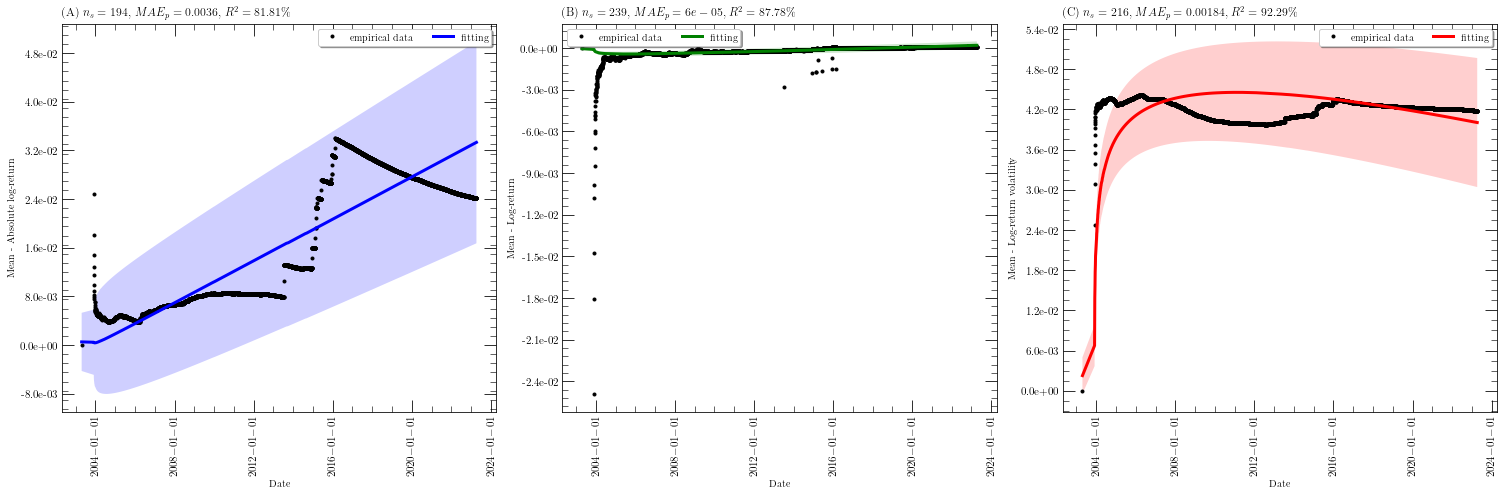

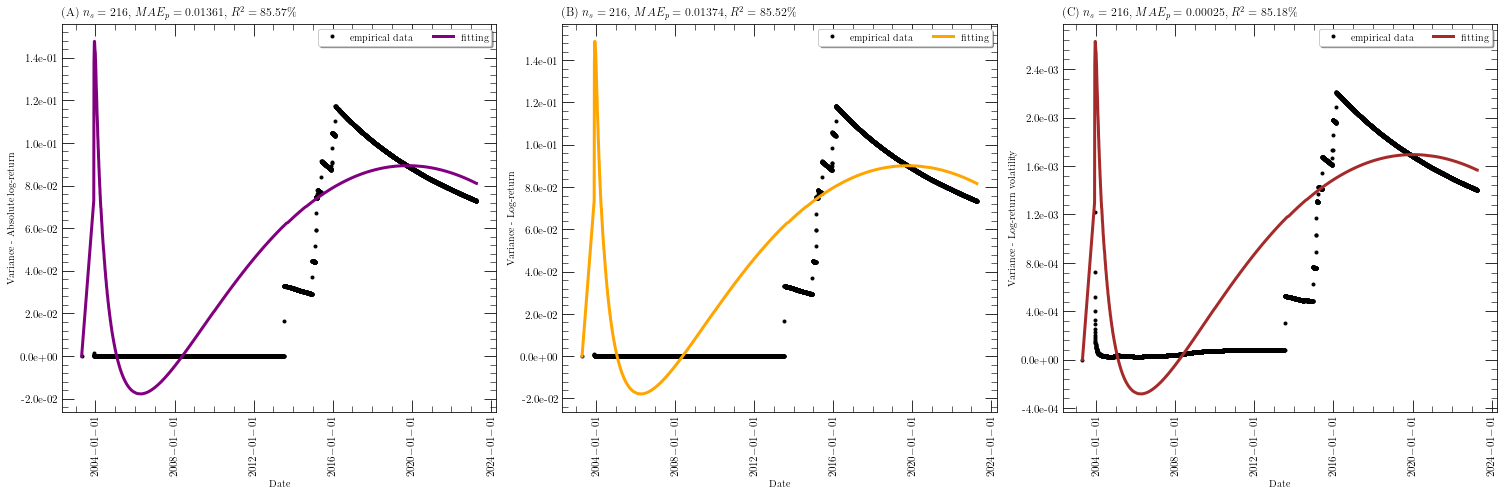

In [10]:
df_graph = plt_ow.plot_optimal_window(
    df_fts = df_currencies,
    df_optimal = df_optimal_currencies,
    interval = "days",
    symbols = ["COP=X"],
    width = 21,
    height = 7,
    all_data = True,
    markersize = 3,
    fontsize_labels = 11,
    fontsize_legend = 10,
    usetex = True,
    n_cols = 4,
    n_x_breaks = 10,
    n_y_breaks = 10,
    fancy_legend = True,
    dpi = 200,
    save_figures = True,
    output_path = "{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)),
    information_name = re.sub("(\^)|(=X)", "", "COP=X"),
    input_generation_date = input_generation_date
)

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return
Generated plot for ^GSPC and time series log-return volatility


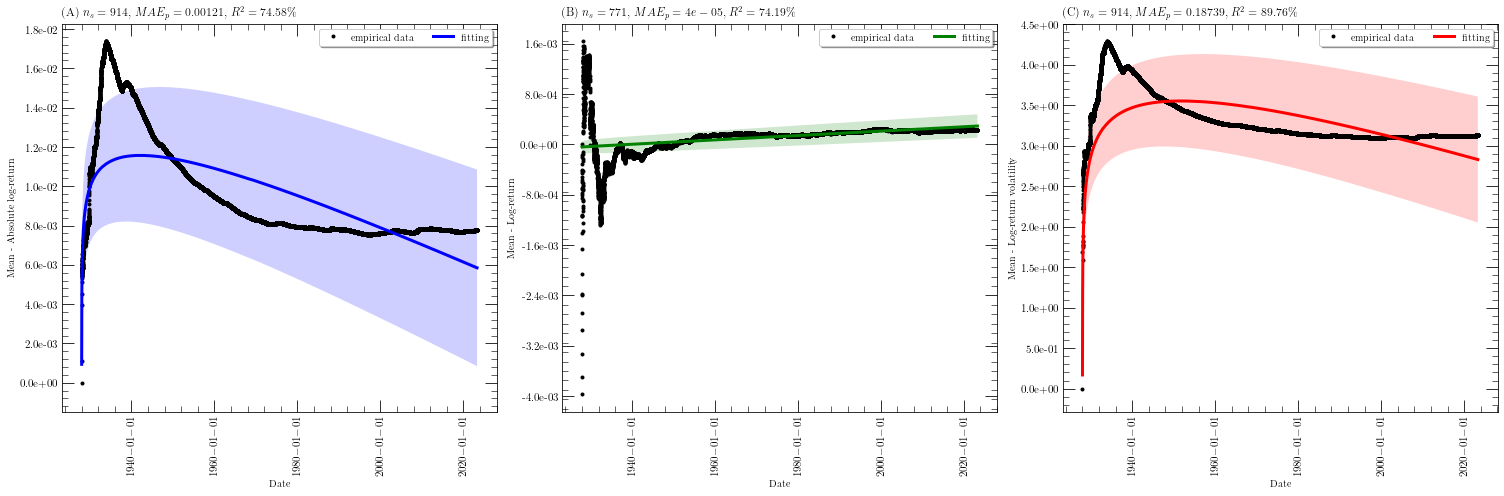

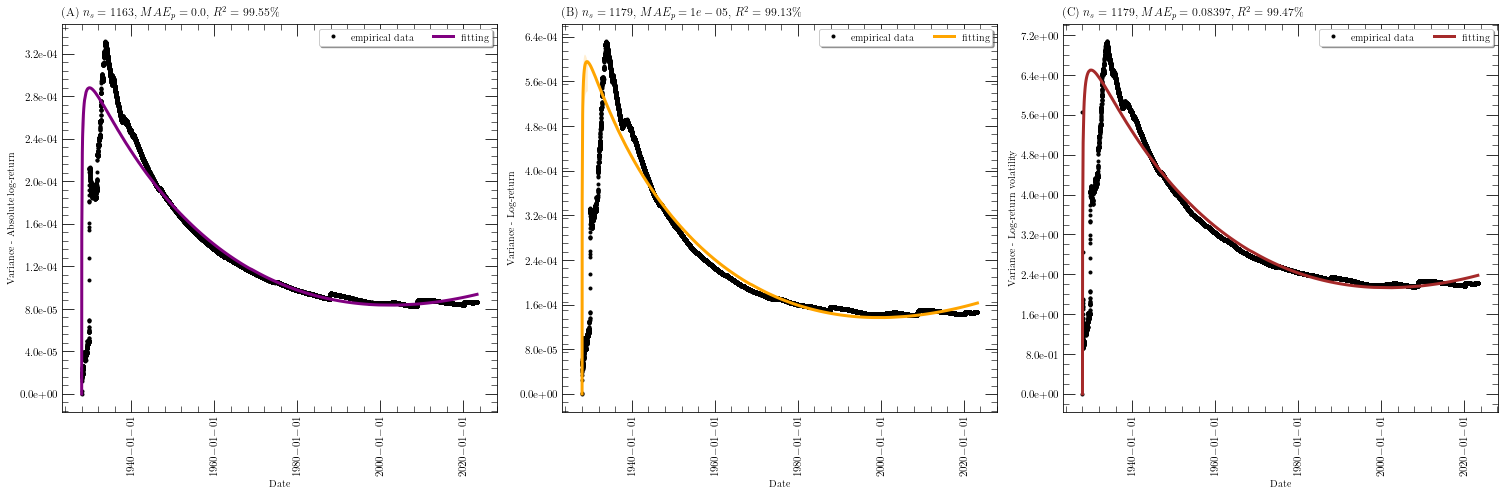

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return
Generated plot for ^DJI and time series log-return volatility


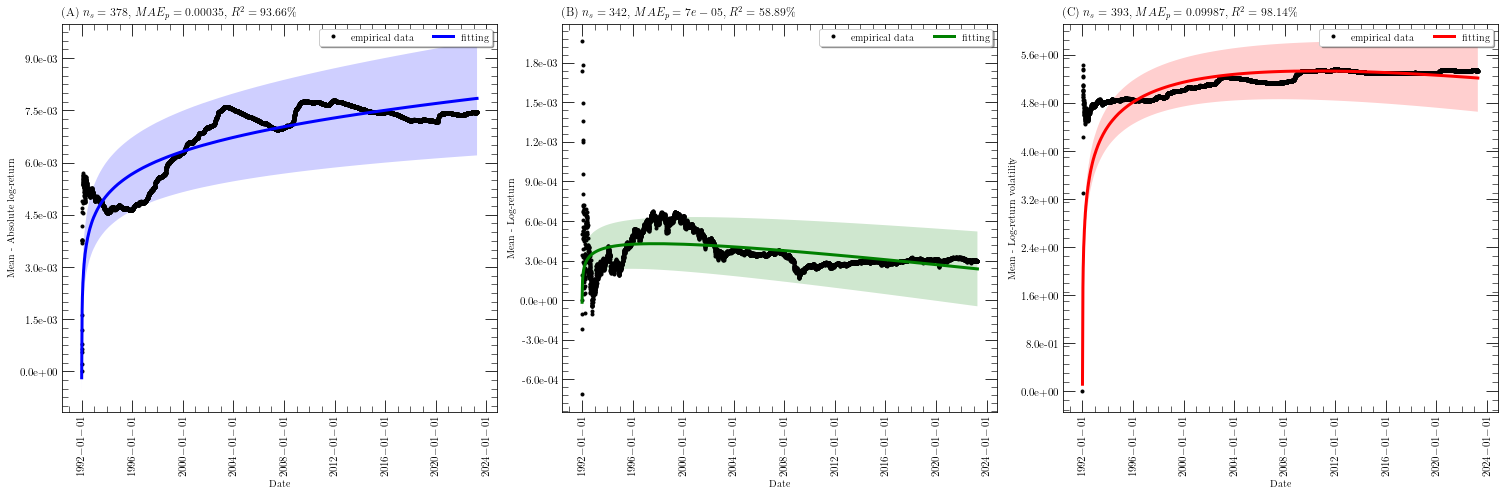

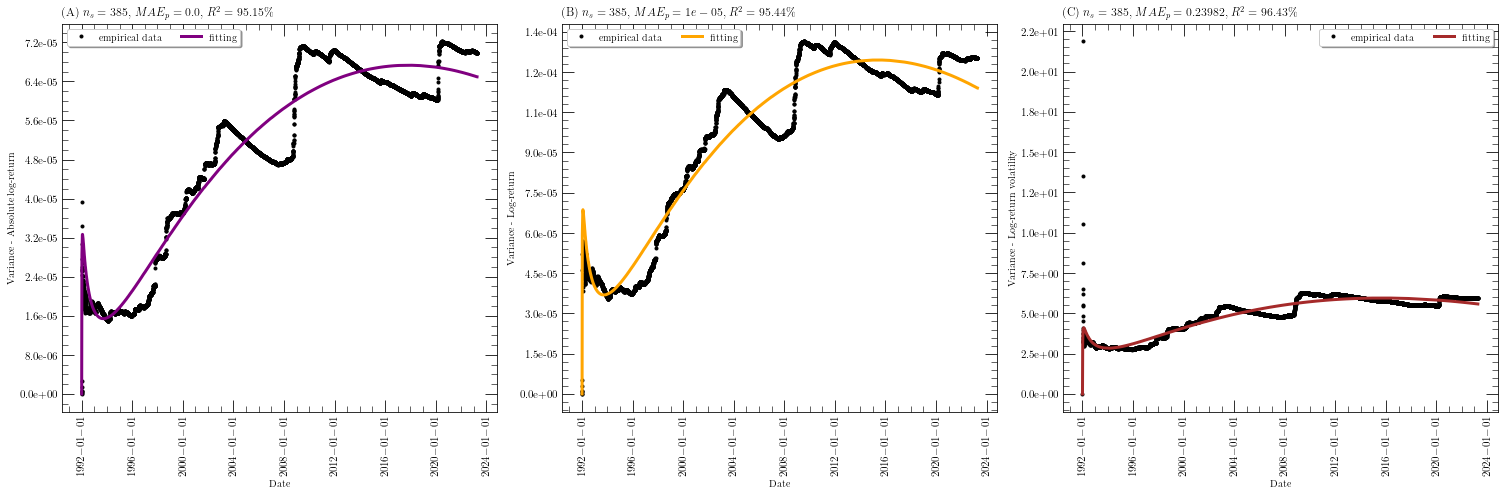

Generated plot for ^W5000 and time series absolute log-return
Generated plot for ^W5000 and time series log-return
Generated plot for ^W5000 and time series log-return volatility


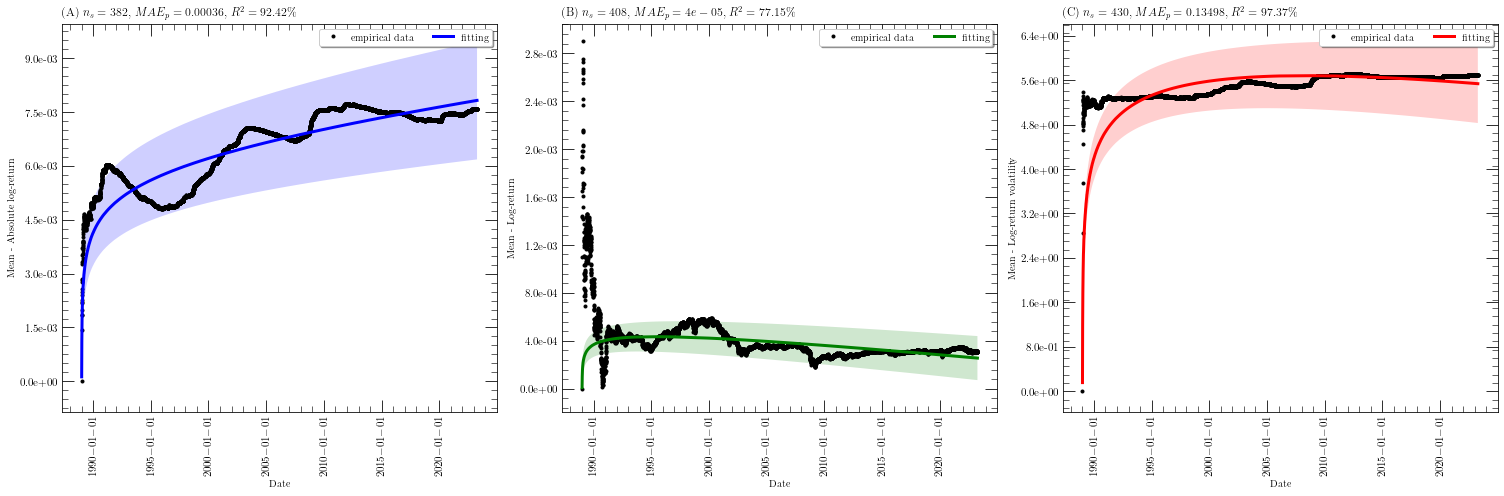

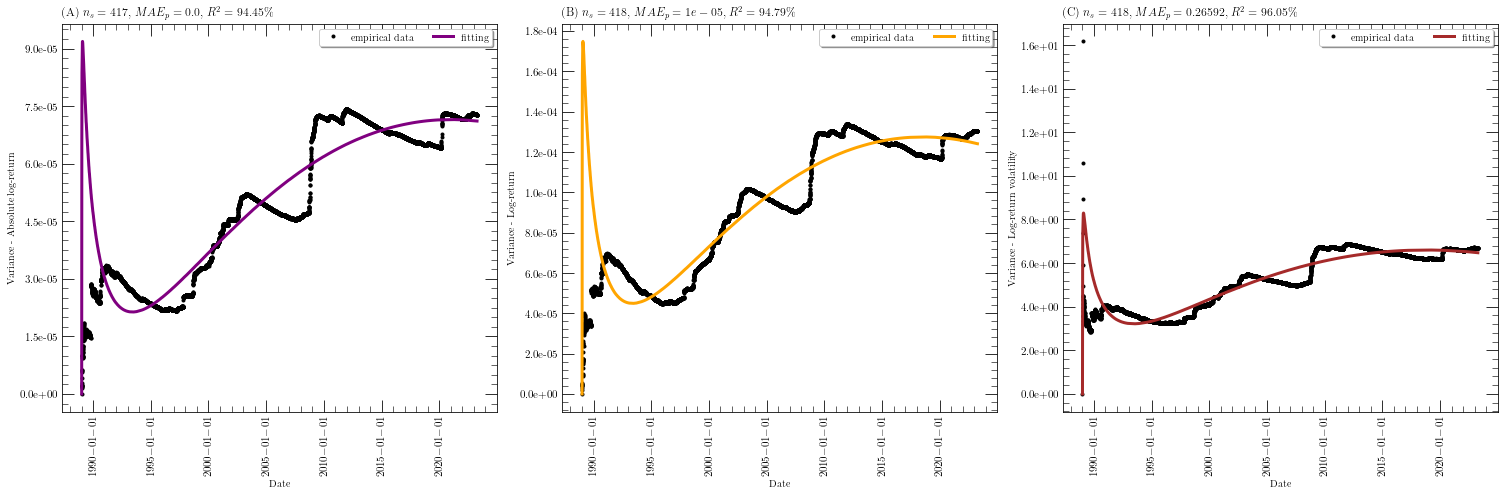

Generated plot for ^GSPTSE and time series absolute log-return
Generated plot for ^GSPTSE and time series log-return
Generated plot for ^GSPTSE and time series log-return volatility


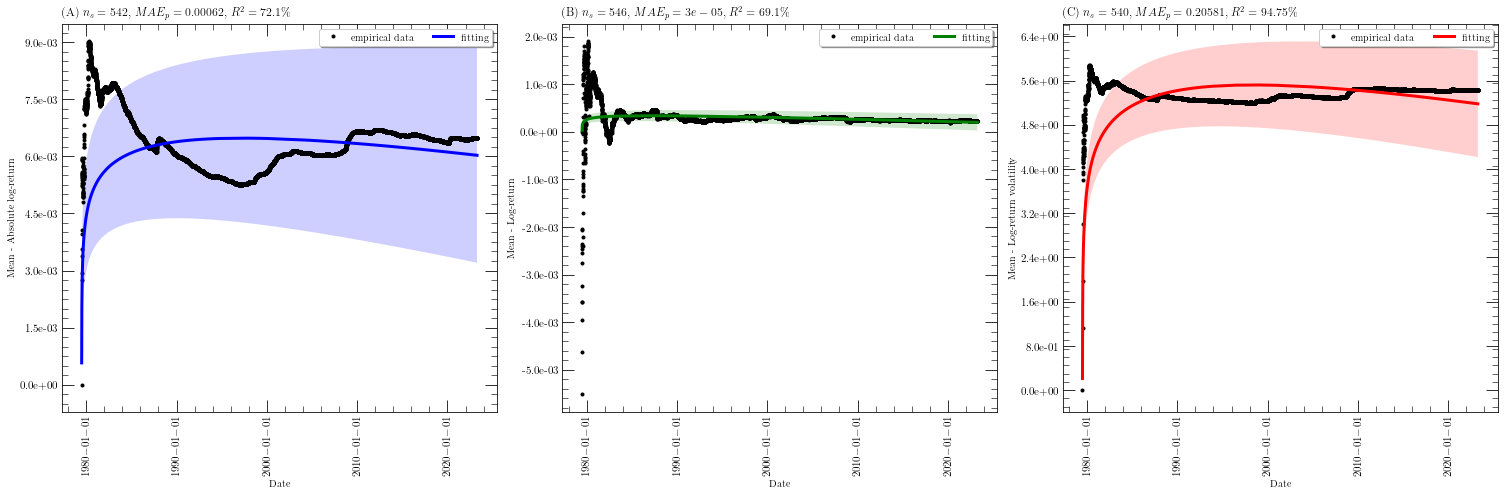

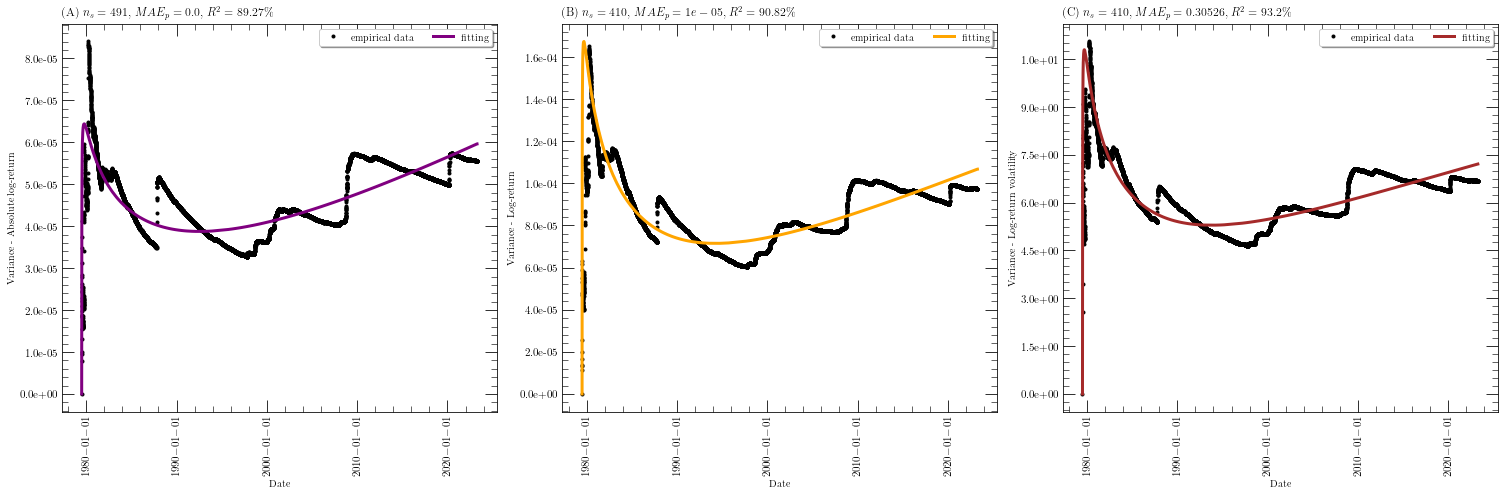

Generated plot for ^GDAXI and time series absolute log-return
Generated plot for ^GDAXI and time series log-return
Generated plot for ^GDAXI and time series log-return volatility


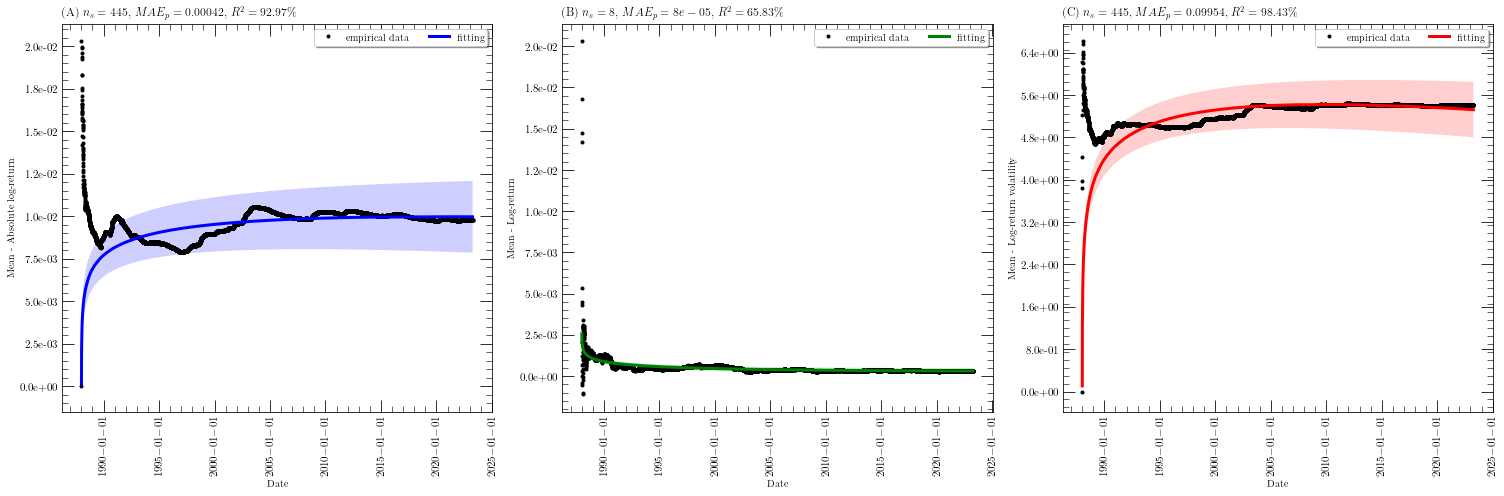

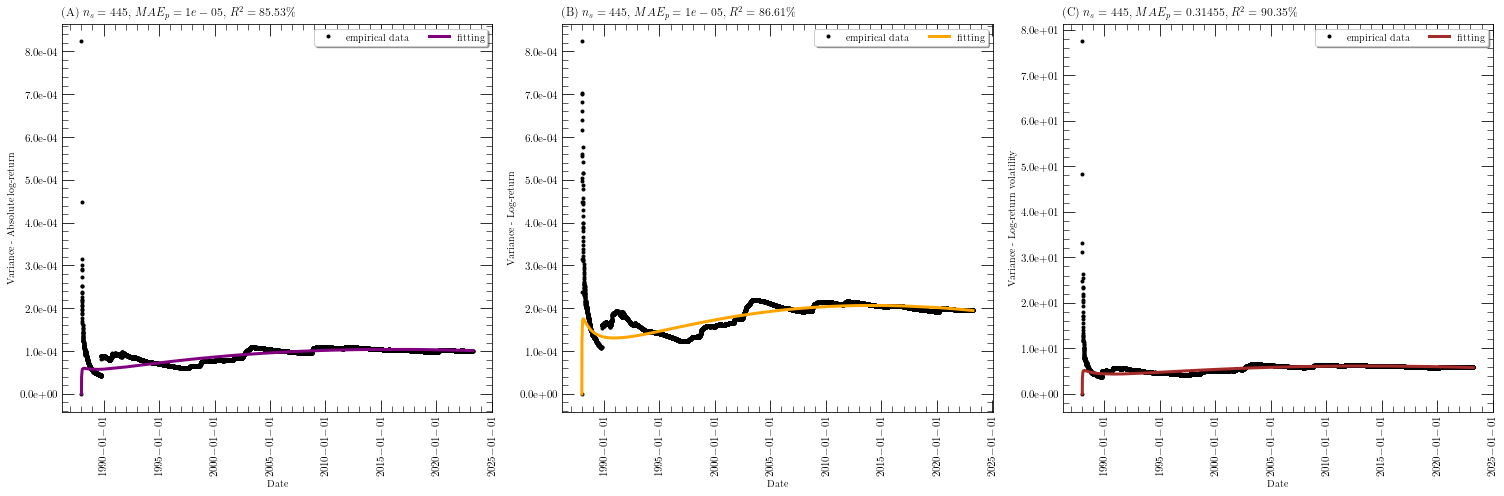

Generated plot for ^FTSE and time series absolute log-return
Generated plot for ^FTSE and time series log-return
Generated plot for ^FTSE and time series log-return volatility


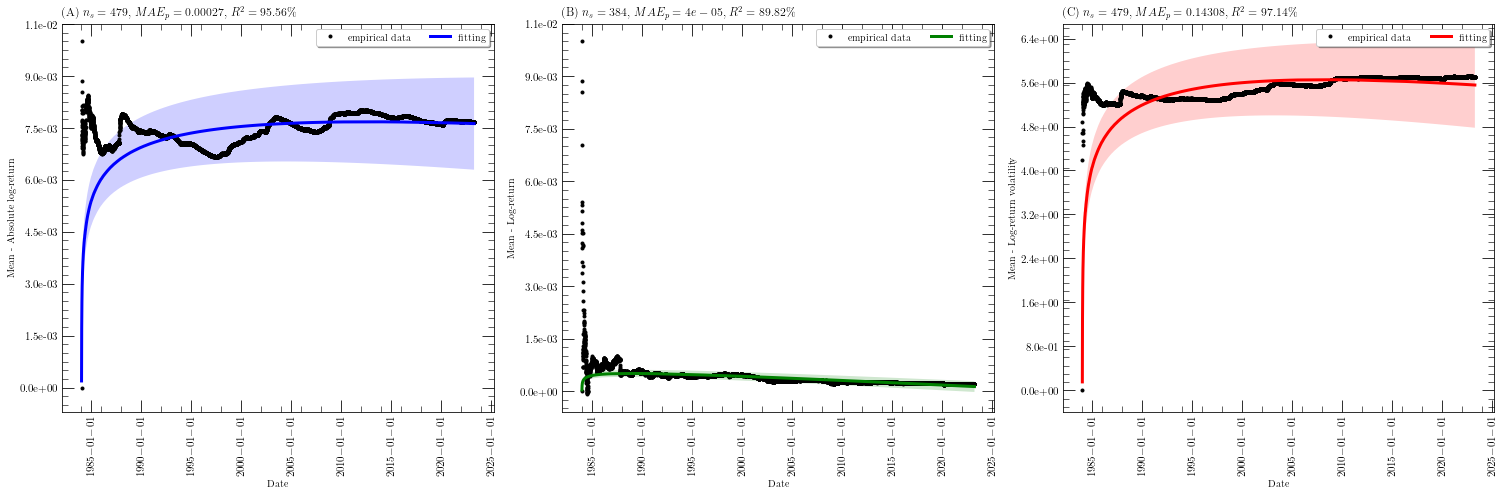

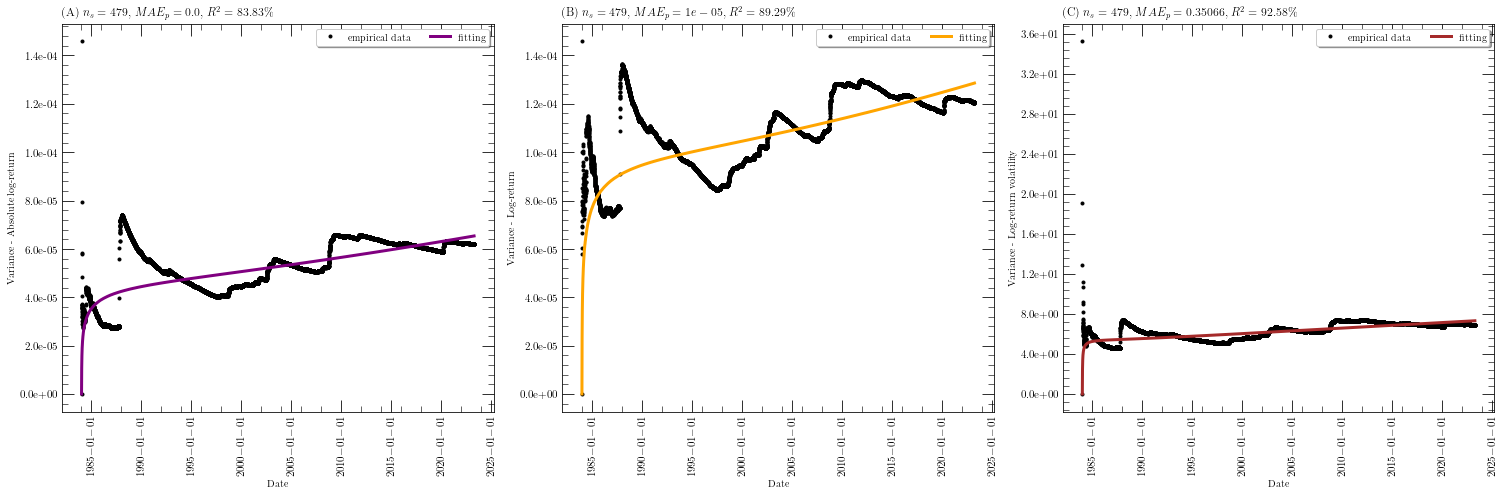

Generated plot for ^FCHI and time series absolute log-return
Generated plot for ^FCHI and time series log-return
Generated plot for ^FCHI and time series log-return volatility


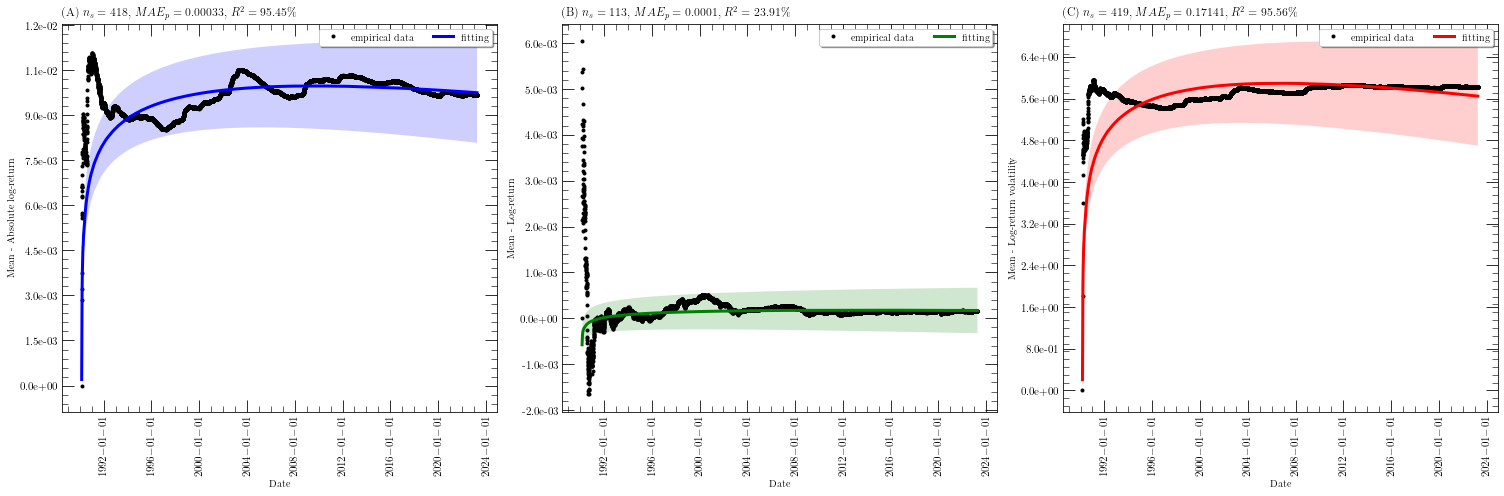

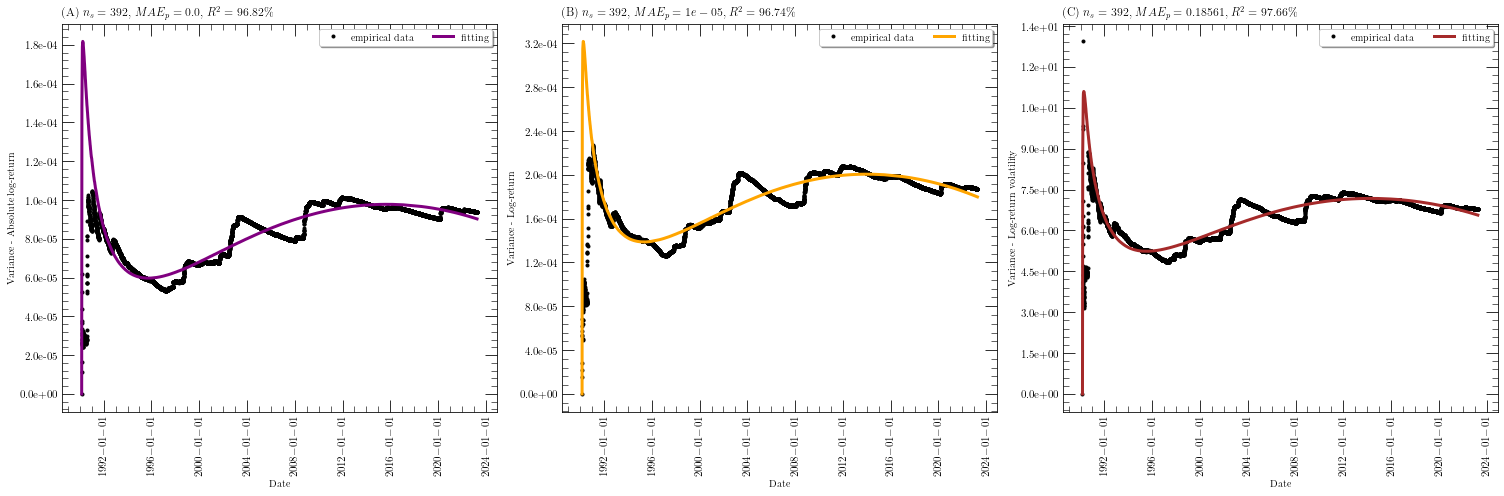

Generated plot for ^IXIC and time series absolute log-return
Generated plot for ^IXIC and time series log-return
Generated plot for ^IXIC and time series log-return volatility


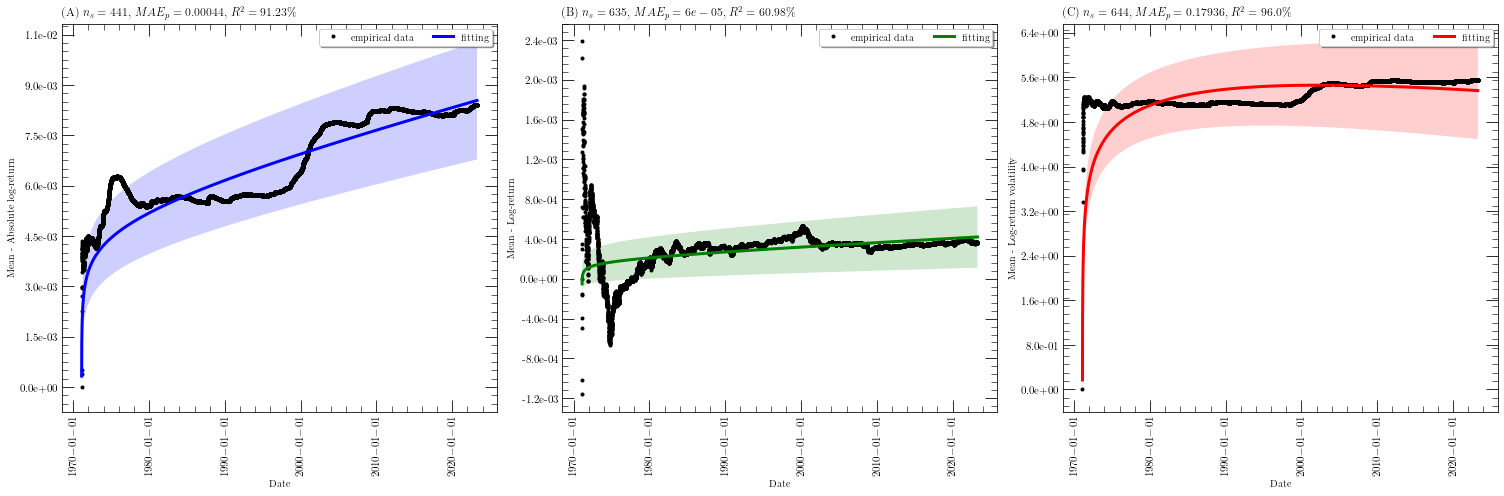

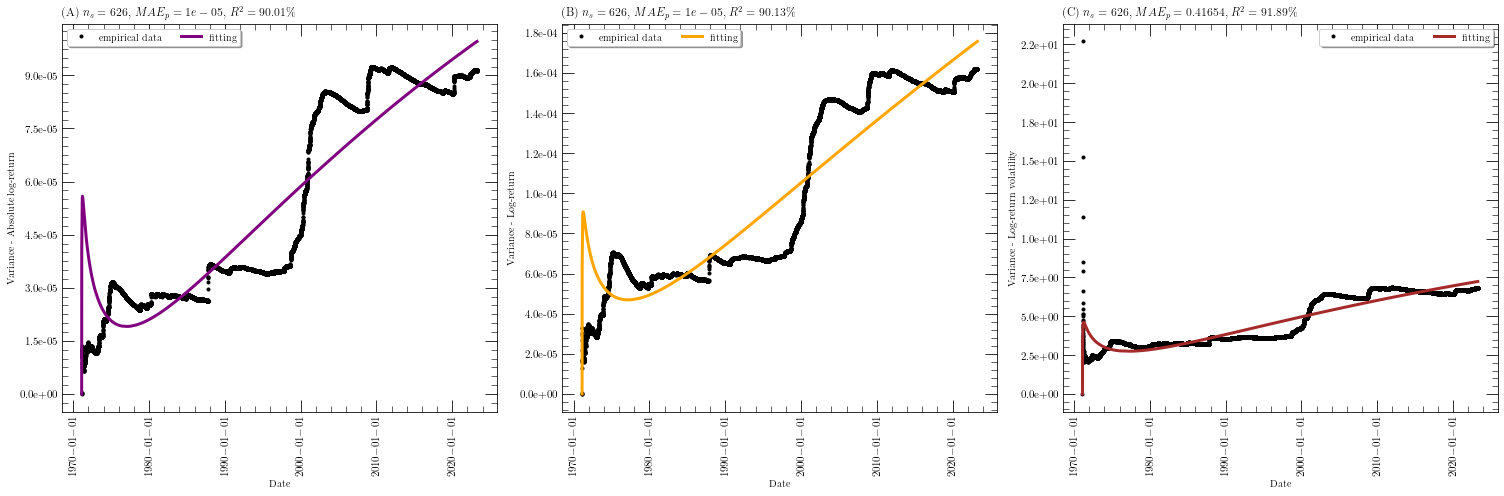

Generated plot for IMOEX.ME and time series absolute log-return
Generated plot for IMOEX.ME and time series log-return
Generated plot for IMOEX.ME and time series log-return volatility


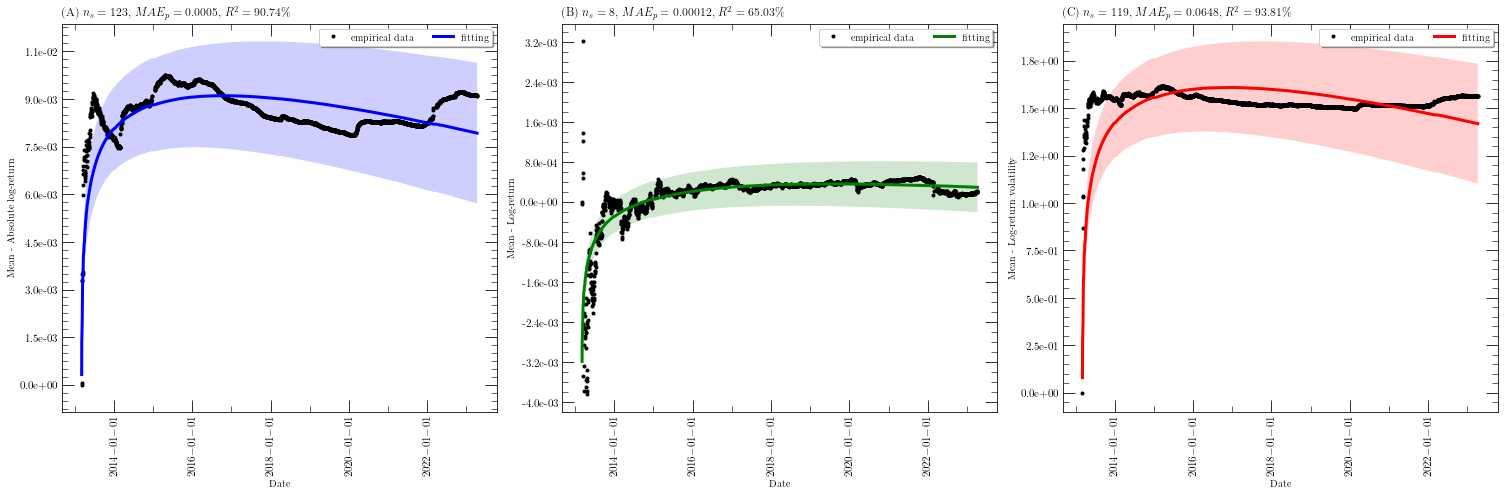

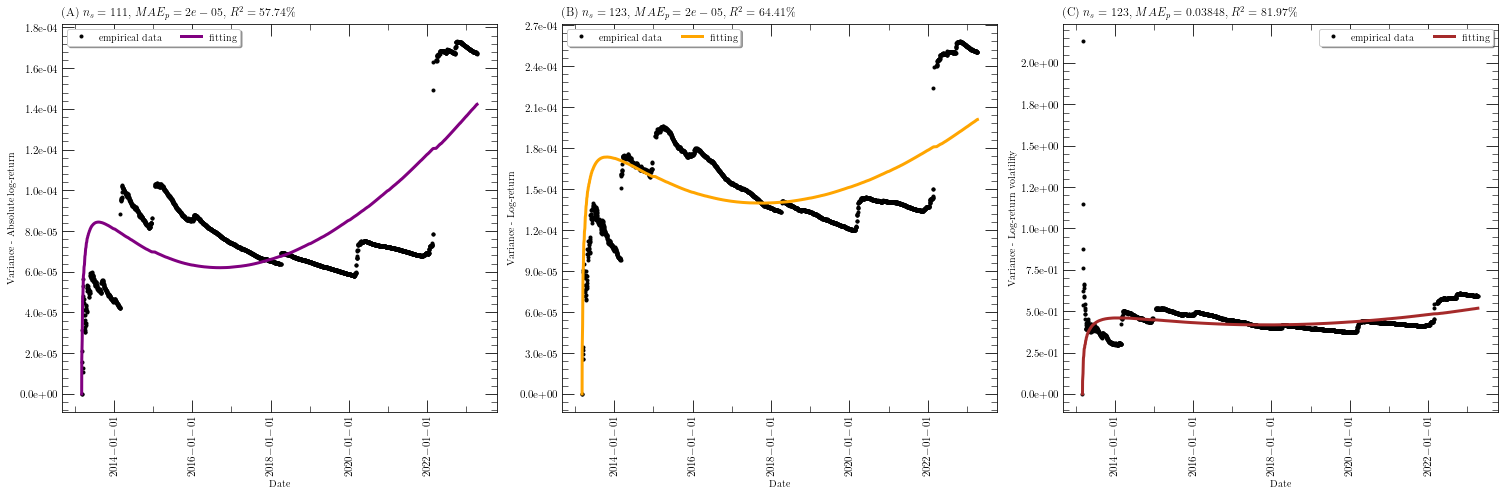

Generated plot for ^N225 and time series absolute log-return
Generated plot for ^N225 and time series log-return
Generated plot for ^N225 and time series log-return volatility


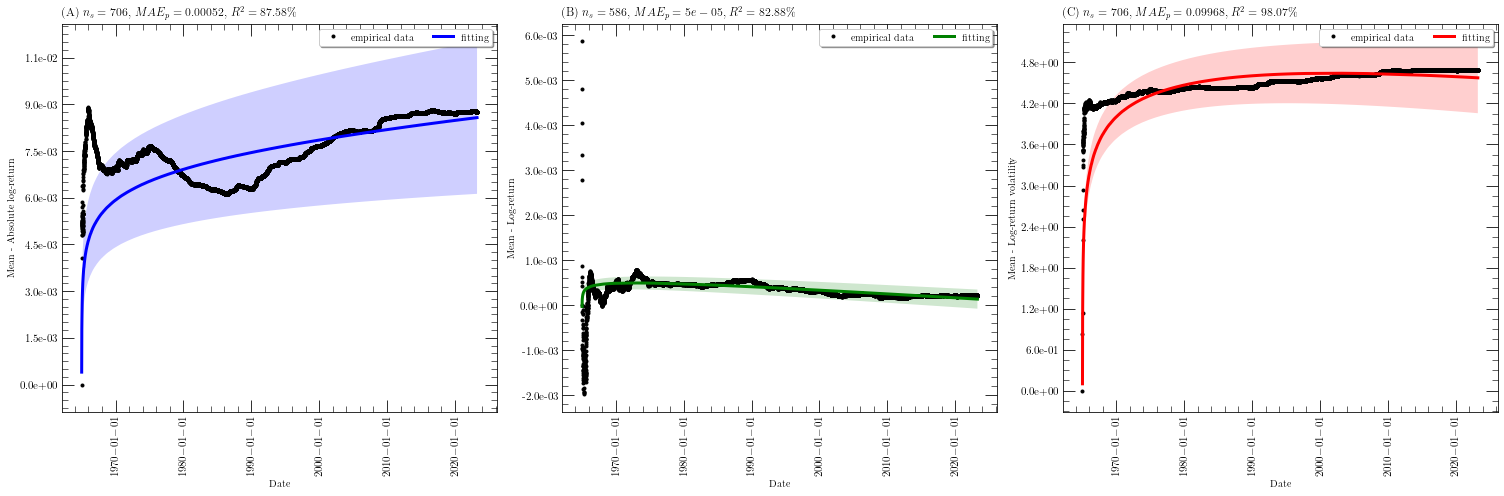

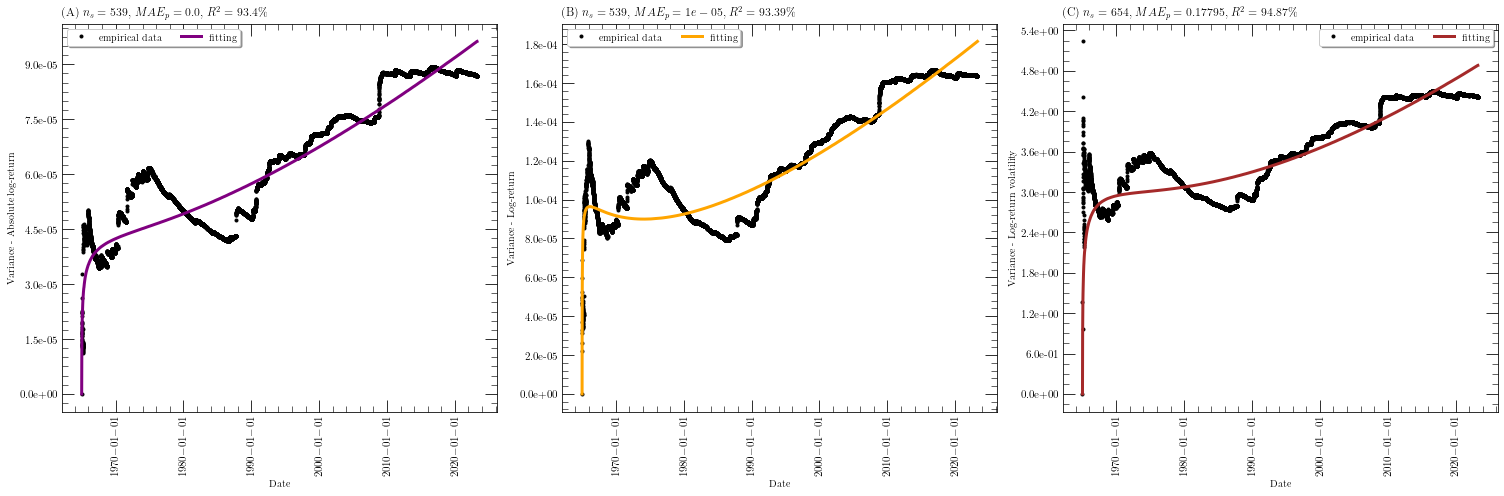

Generated plot for ^STI and time series absolute log-return
Generated plot for ^STI and time series log-return
Generated plot for ^STI and time series log-return volatility


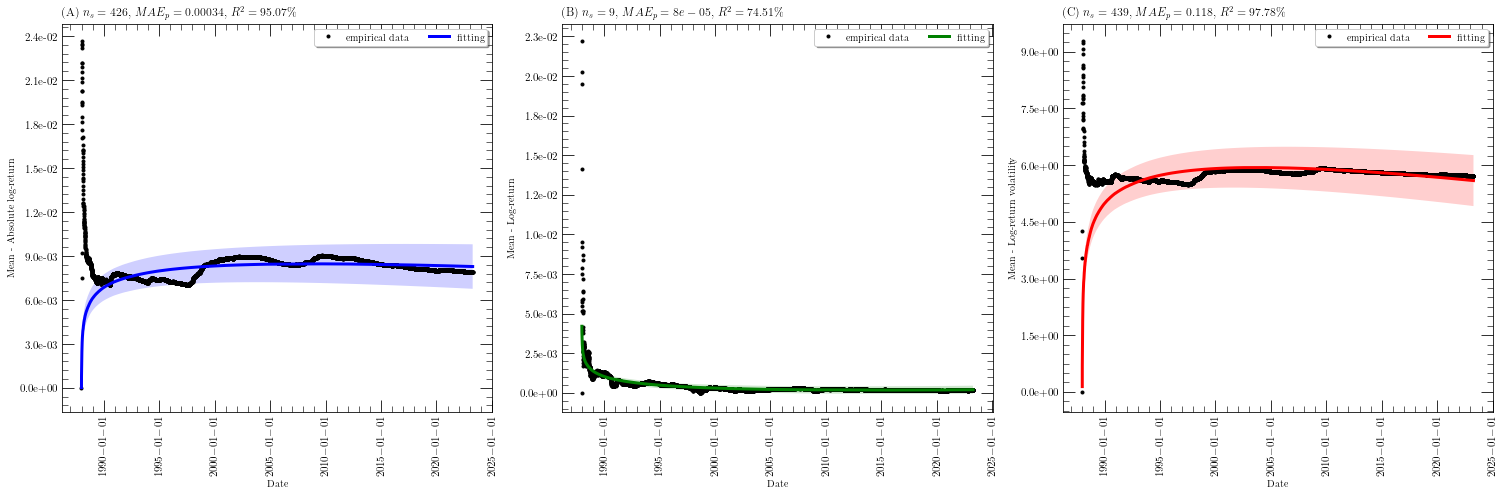

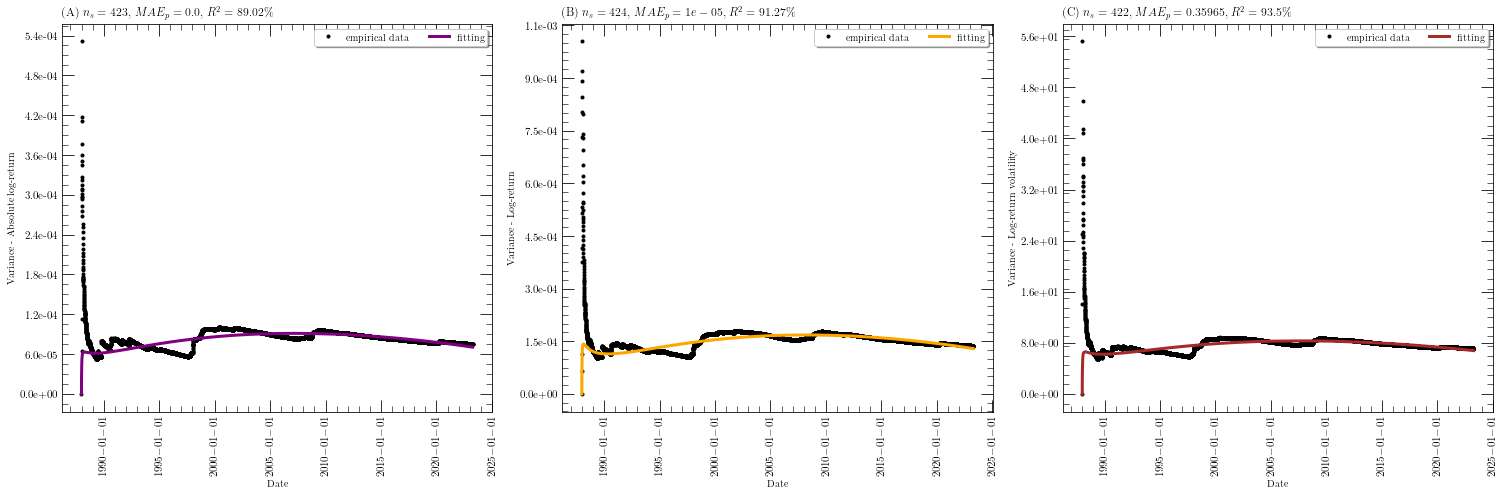

Generated plot for ^BVSP and time series absolute log-return
Generated plot for ^BVSP and time series log-return
Generated plot for ^BVSP and time series log-return volatility


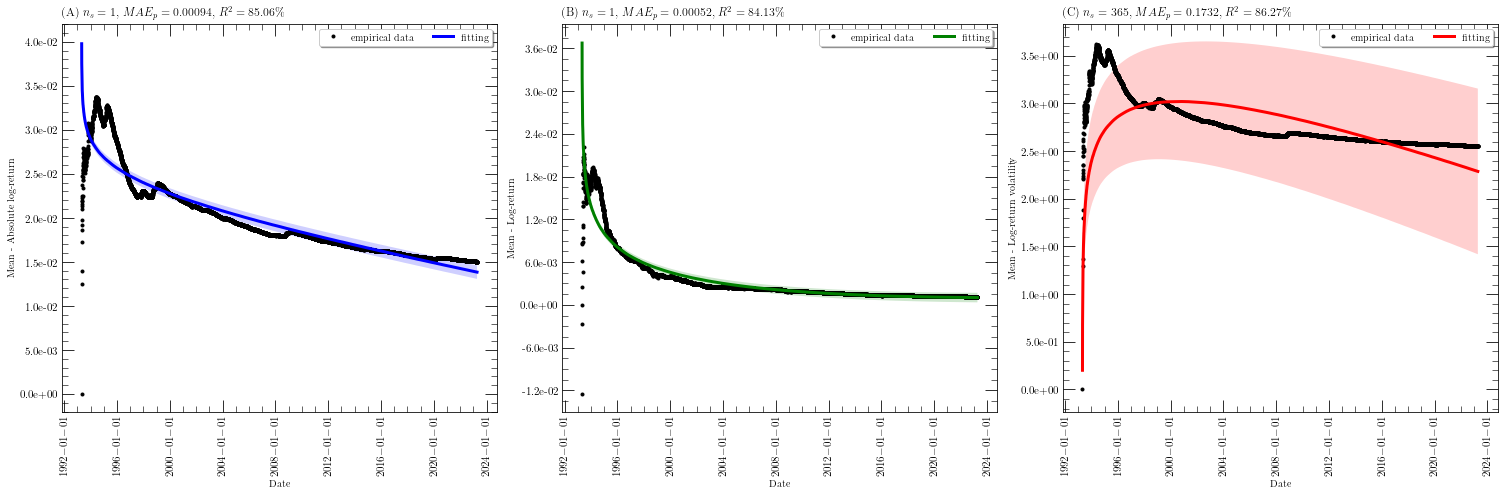

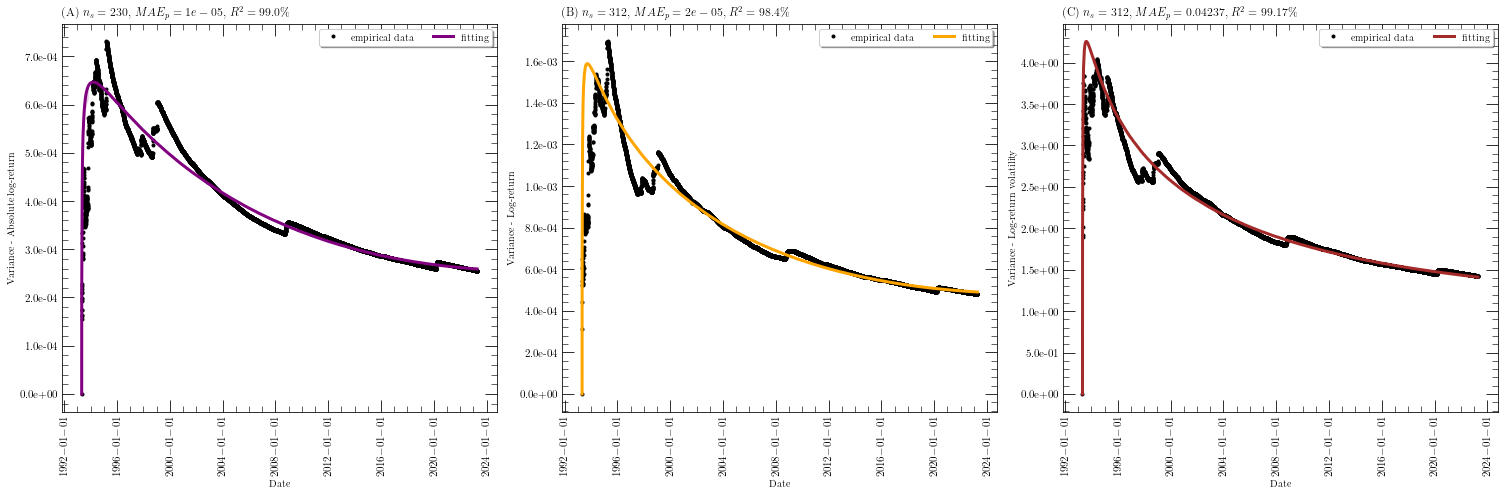

Generated plot for ^MERV and time series absolute log-return
Generated plot for ^MERV and time series log-return
Generated plot for ^MERV and time series log-return volatility


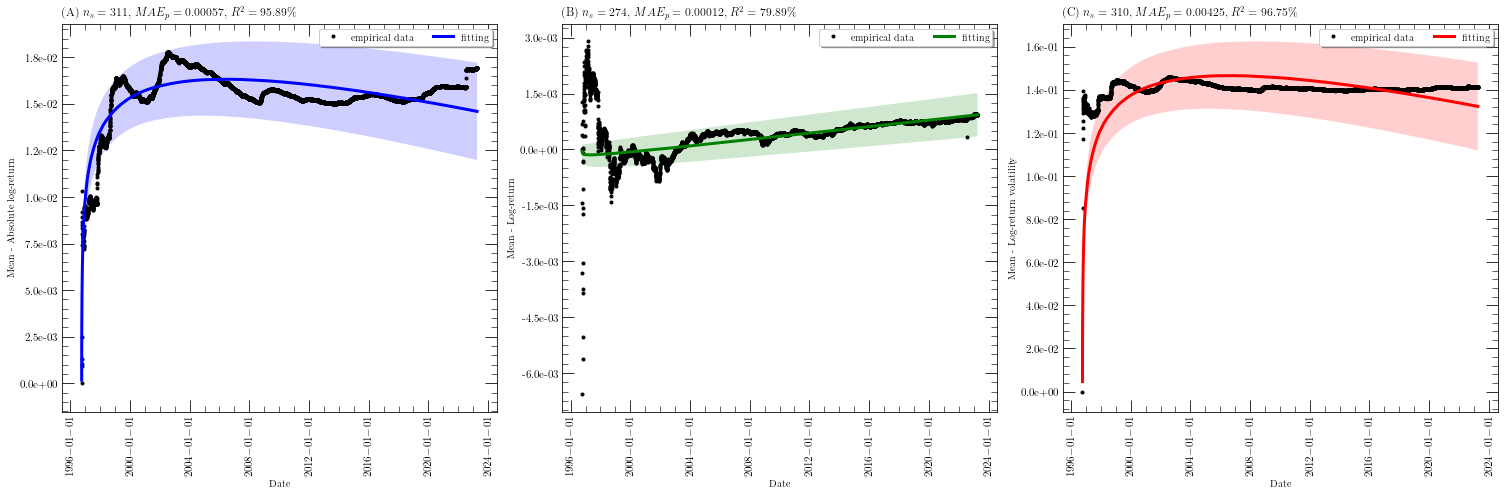

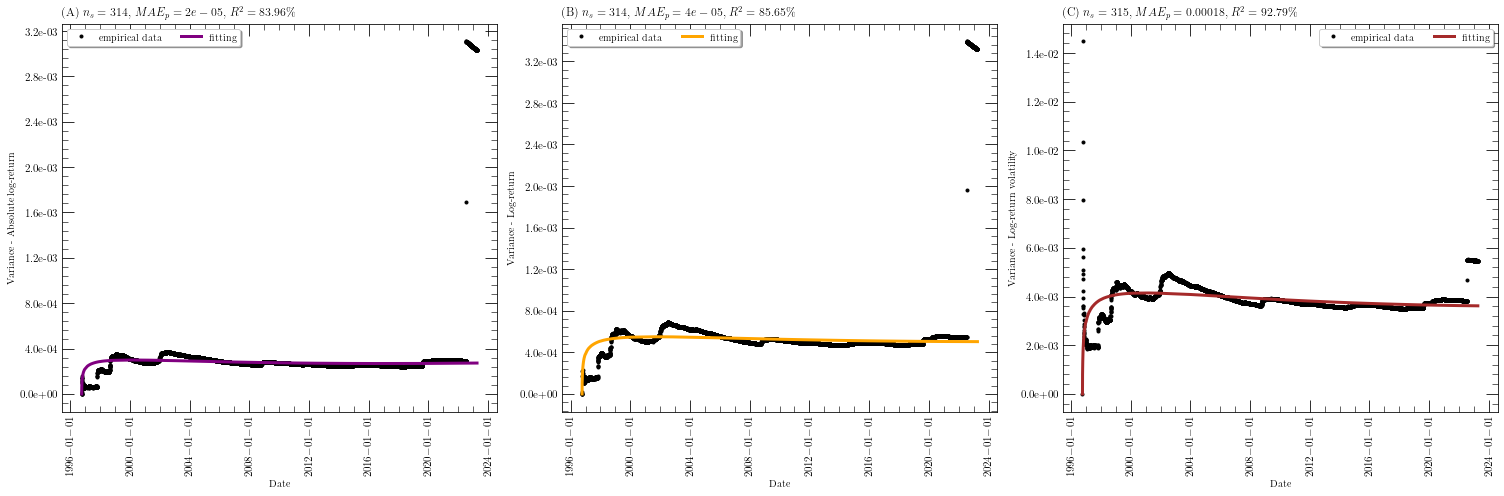

In [11]:
for ticker, ticker_name in list_stock_indexes.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = df_stock_indexes,
        df_optimal = df_optimal_stock_indexes,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 11,
        fontsize_legend = 10,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 10,
        n_y_breaks = 10,
        fancy_legend = True,
        dpi = 200,
        save_figures = True,
        output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = re.sub("(\^)|(=X)", "", ticker),
        input_generation_date = input_generation_date
    )

Generated plot for KWDUSD=X and time series absolute log-return
Generated plot for KWDUSD=X and time series log-return
Generated plot for KWDUSD=X and time series log-return volatility


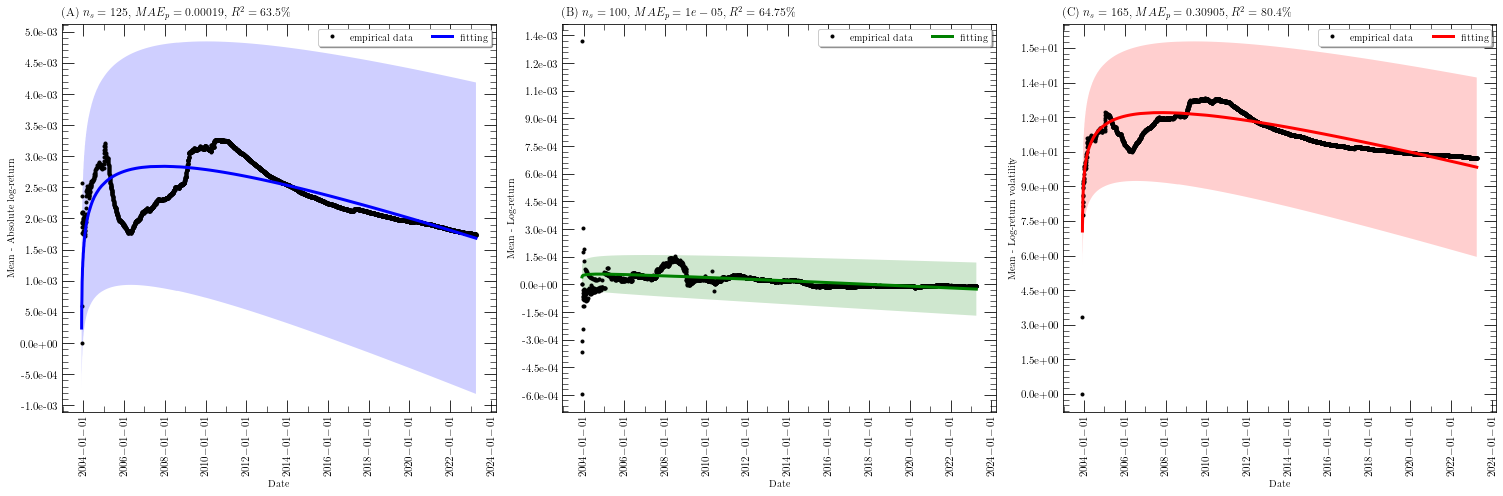

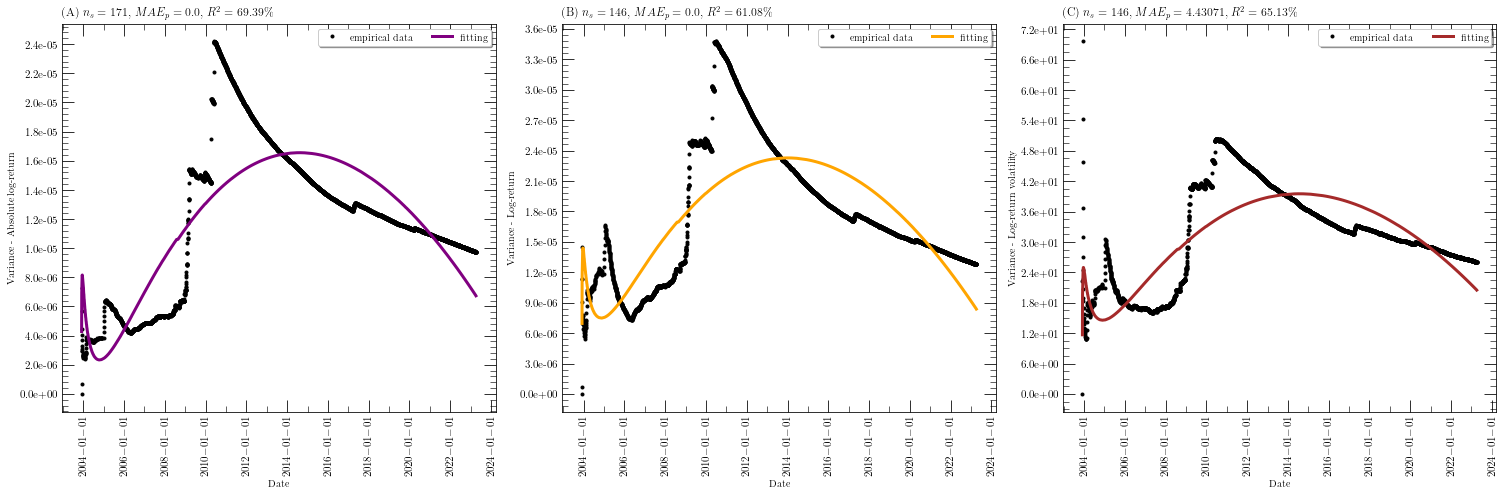

Generated plot for BHDUSD=X and time series absolute log-return
Generated plot for BHDUSD=X and time series log-return
Generated plot for BHDUSD=X and time series log-return volatility


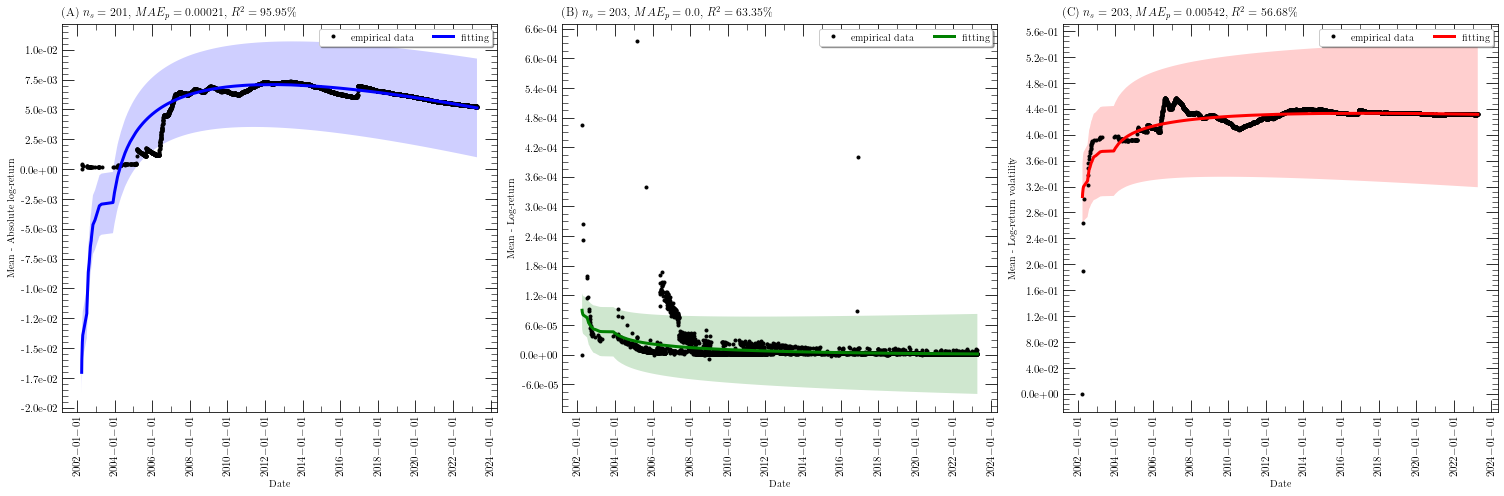

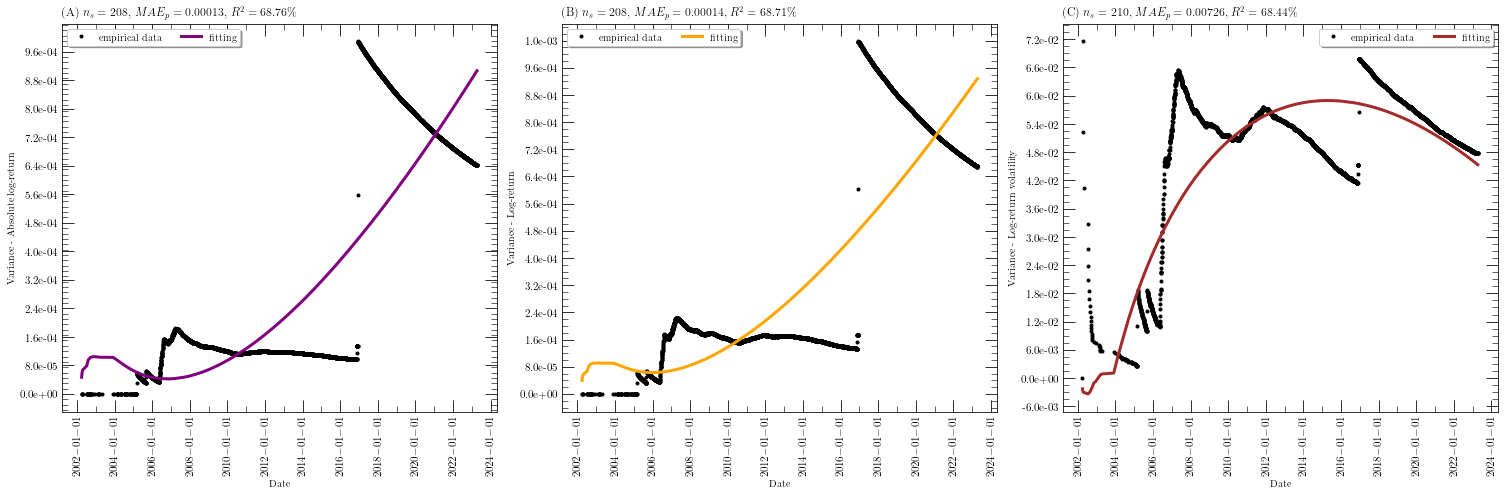

Generated plot for OMRUSD=X and time series absolute log-return
Generated plot for OMRUSD=X and time series log-return
Generated plot for OMRUSD=X and time series log-return volatility


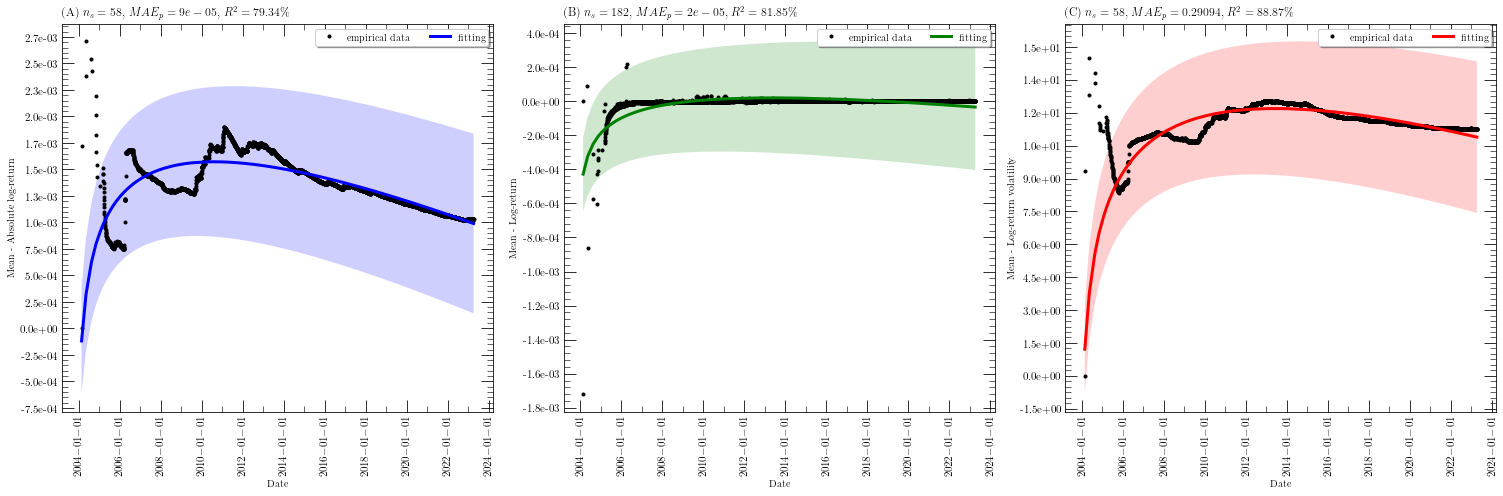

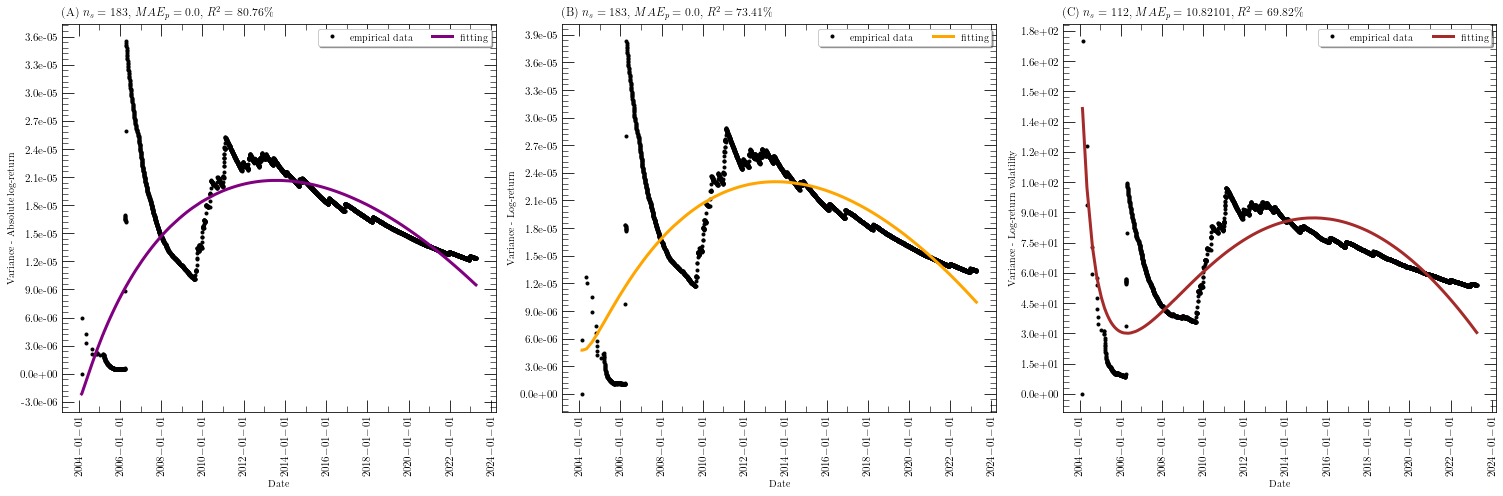

Generated plot for JODUSD=X and time series absolute log-return
Generated plot for JODUSD=X and time series log-return
Generated plot for JODUSD=X and time series log-return volatility


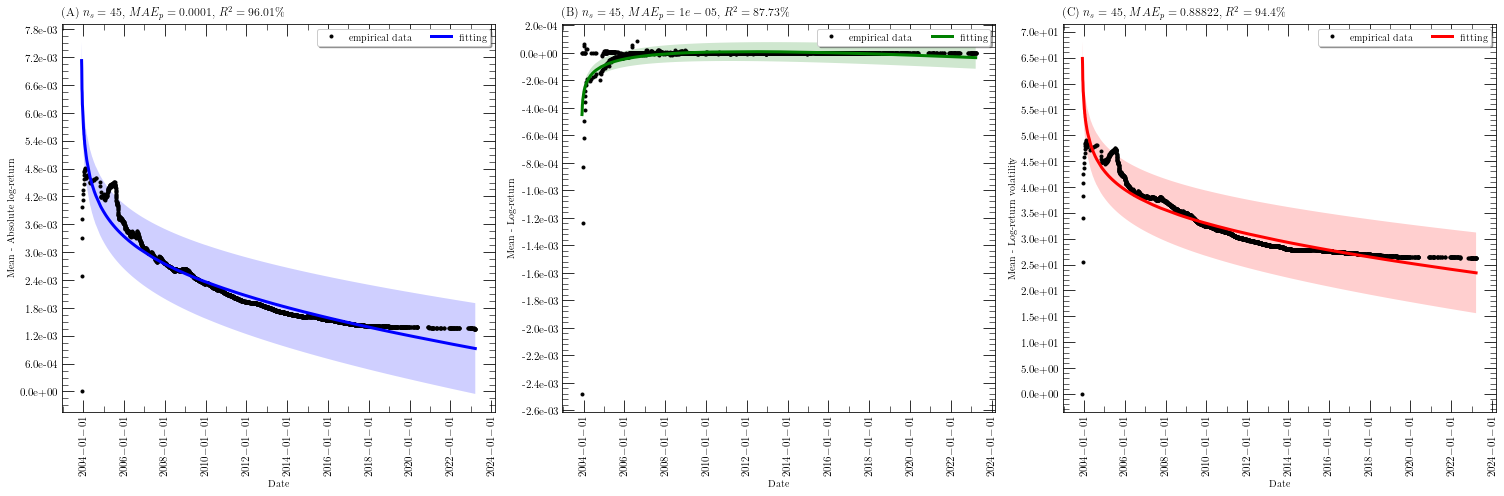

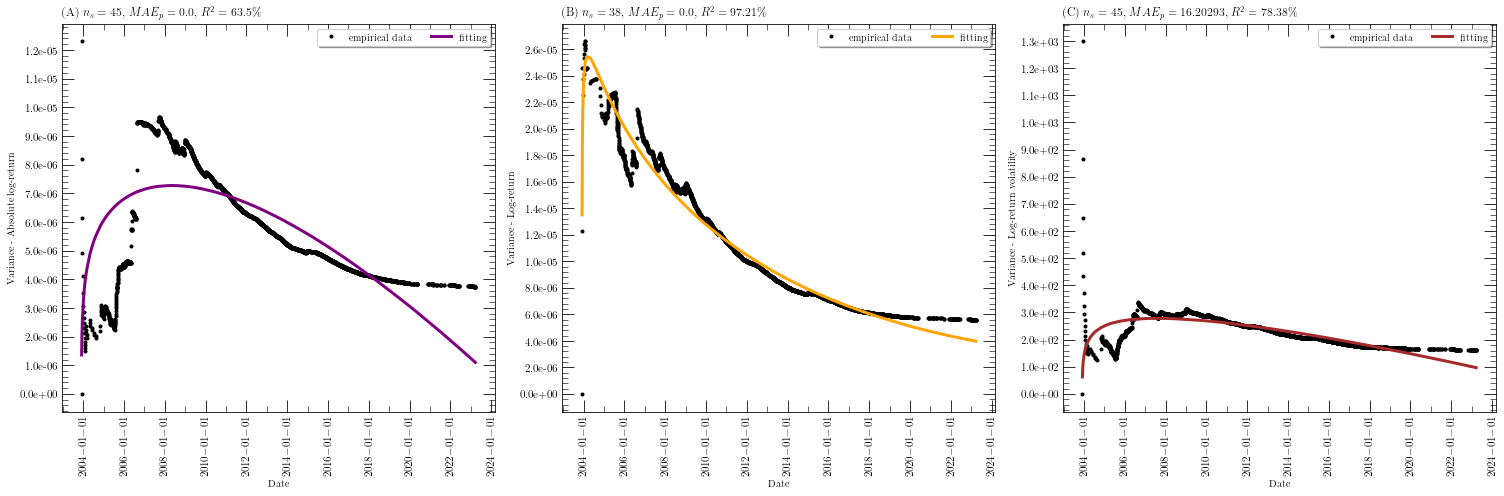

Generated plot for KYDUSD=X and time series absolute log-return
Generated plot for KYDUSD=X and time series log-return
Generated plot for KYDUSD=X and time series log-return volatility


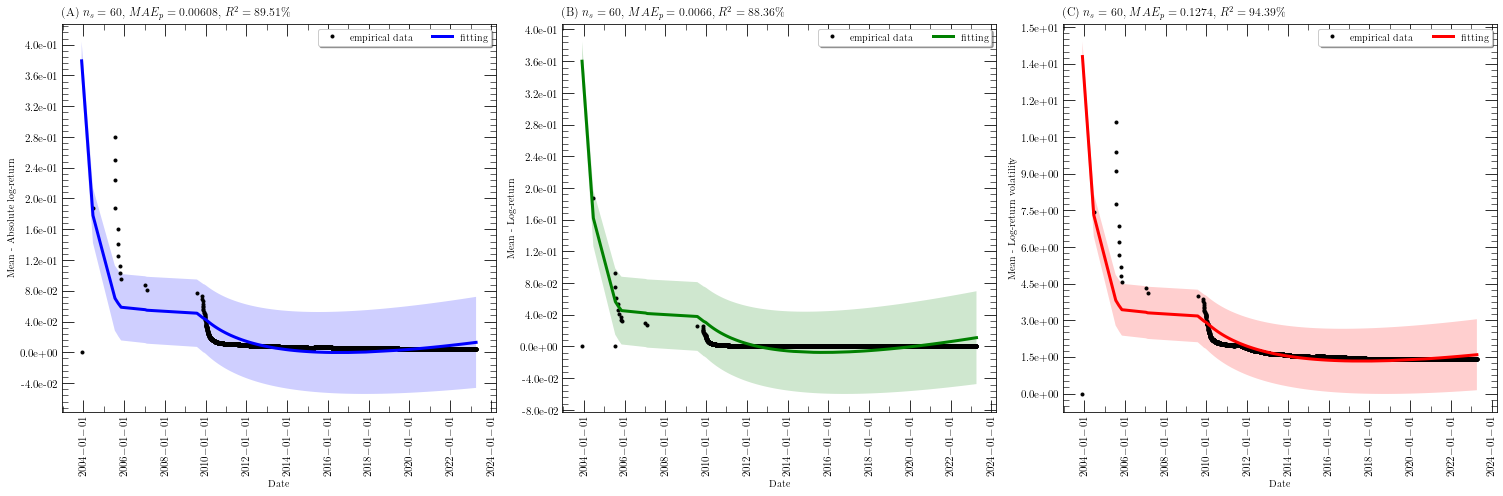

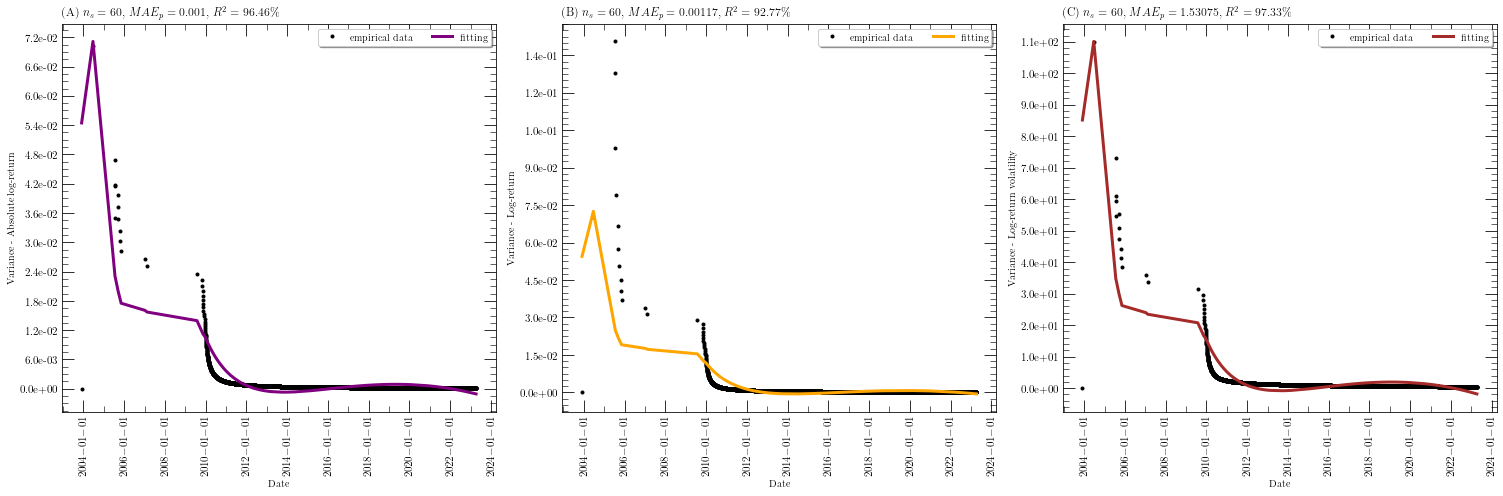

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return
Generated plot for GBPUSD=X and time series log-return volatility


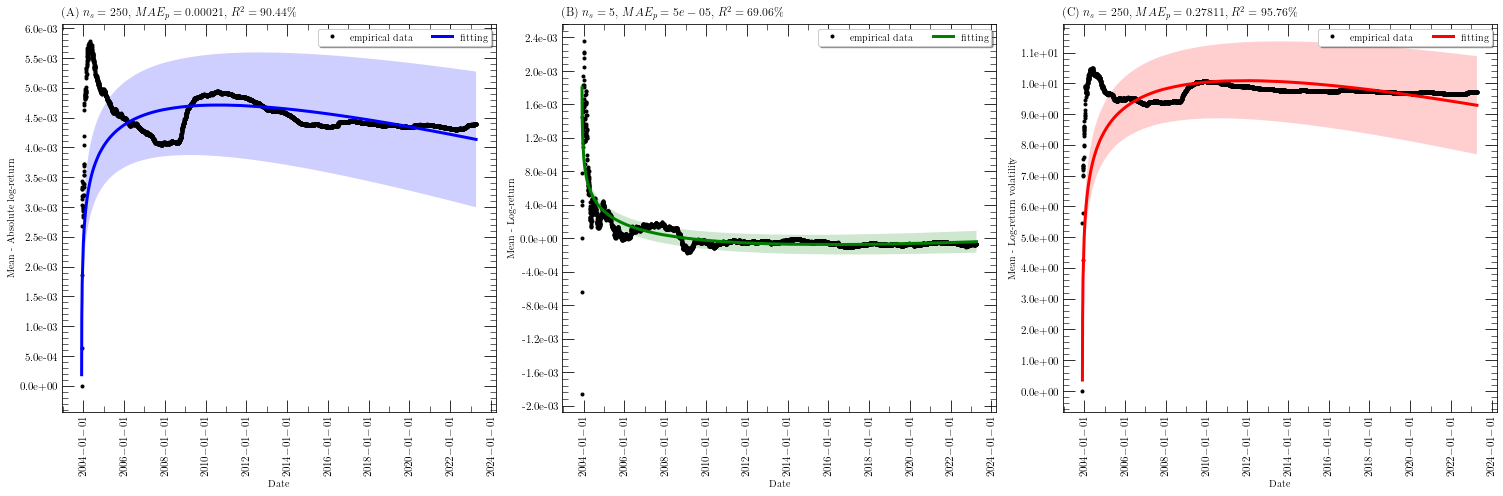

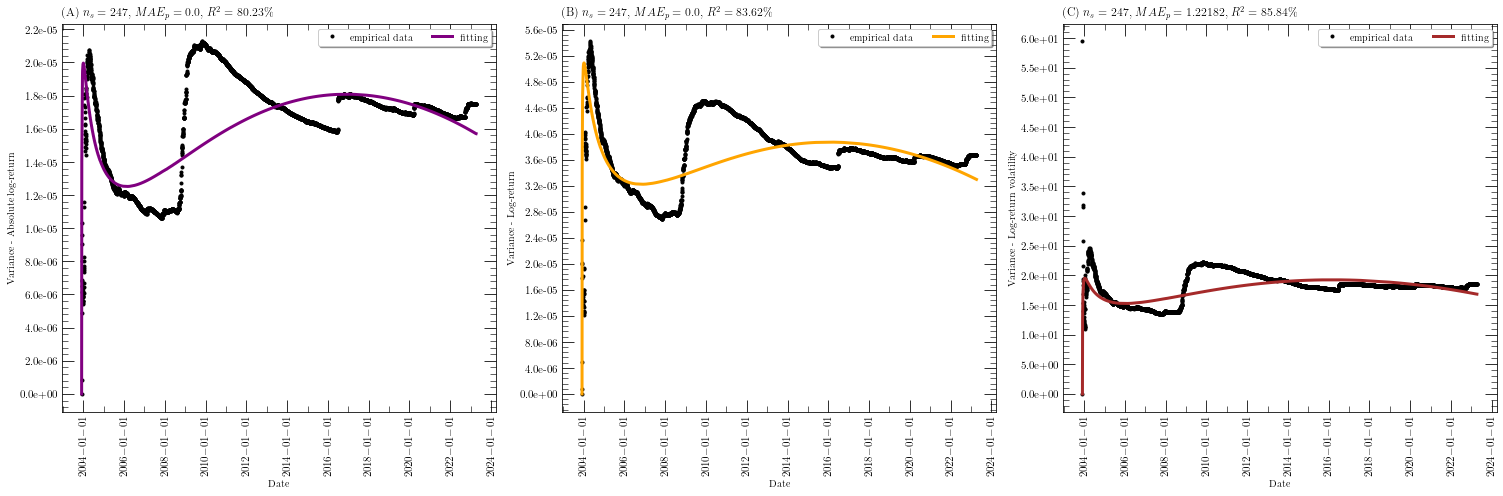

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


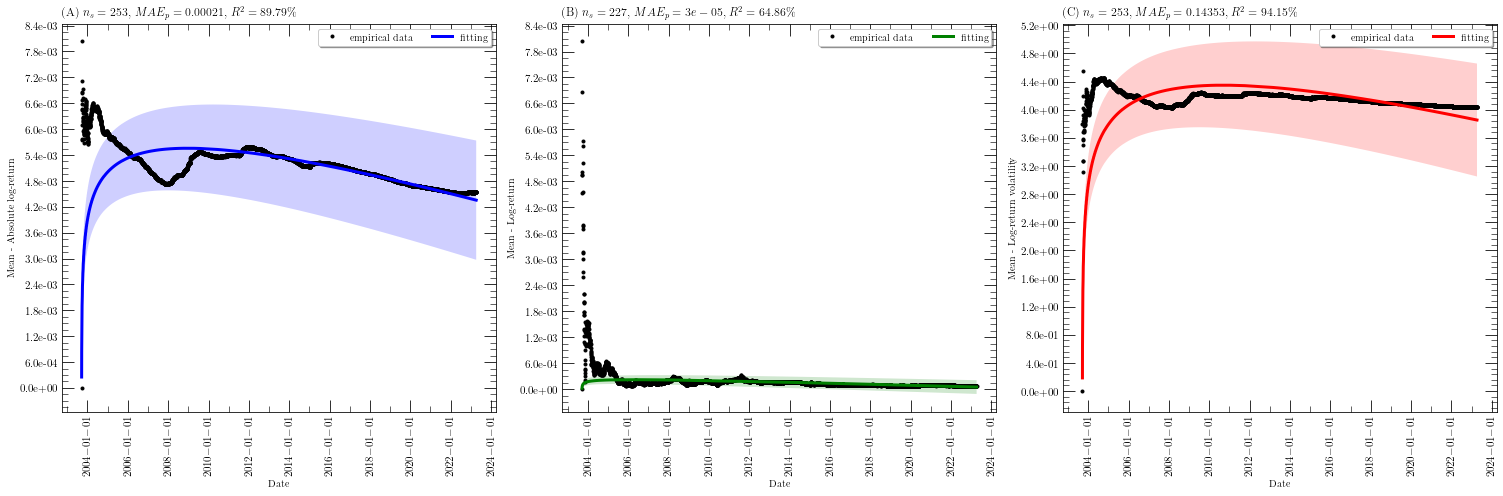

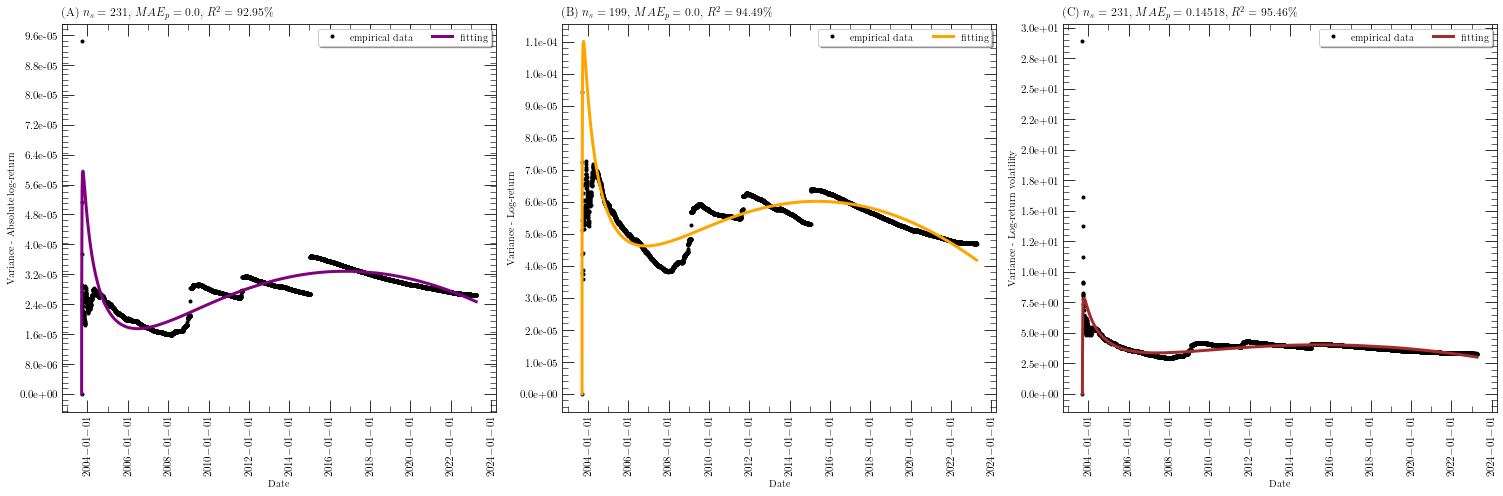

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return
Generated plot for EURUSD=X and time series log-return volatility


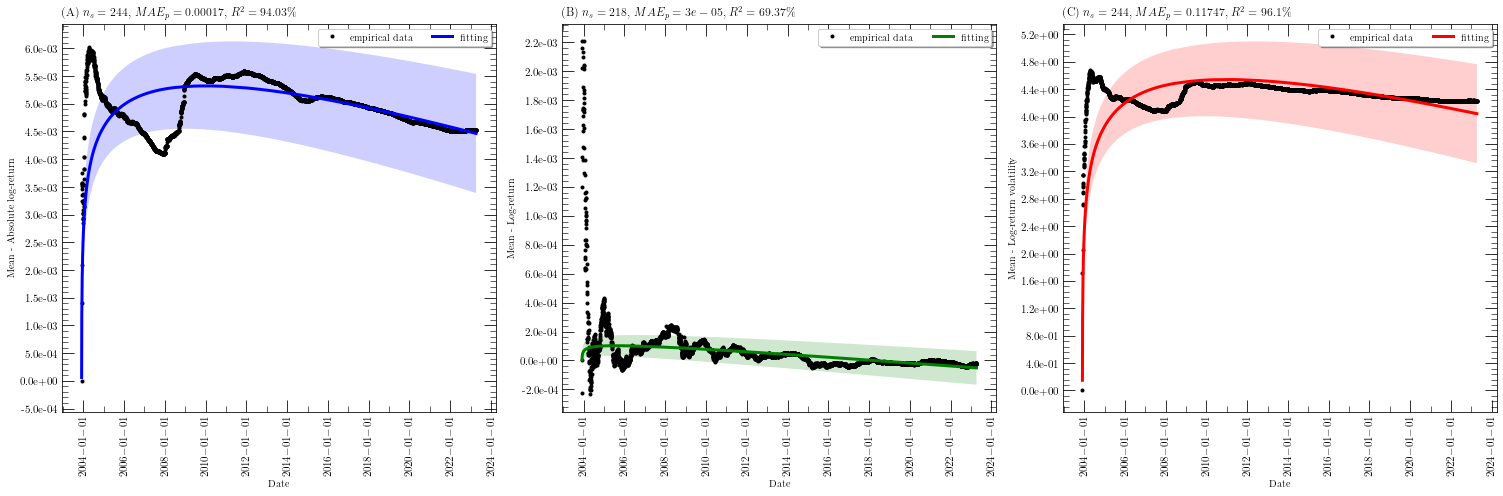

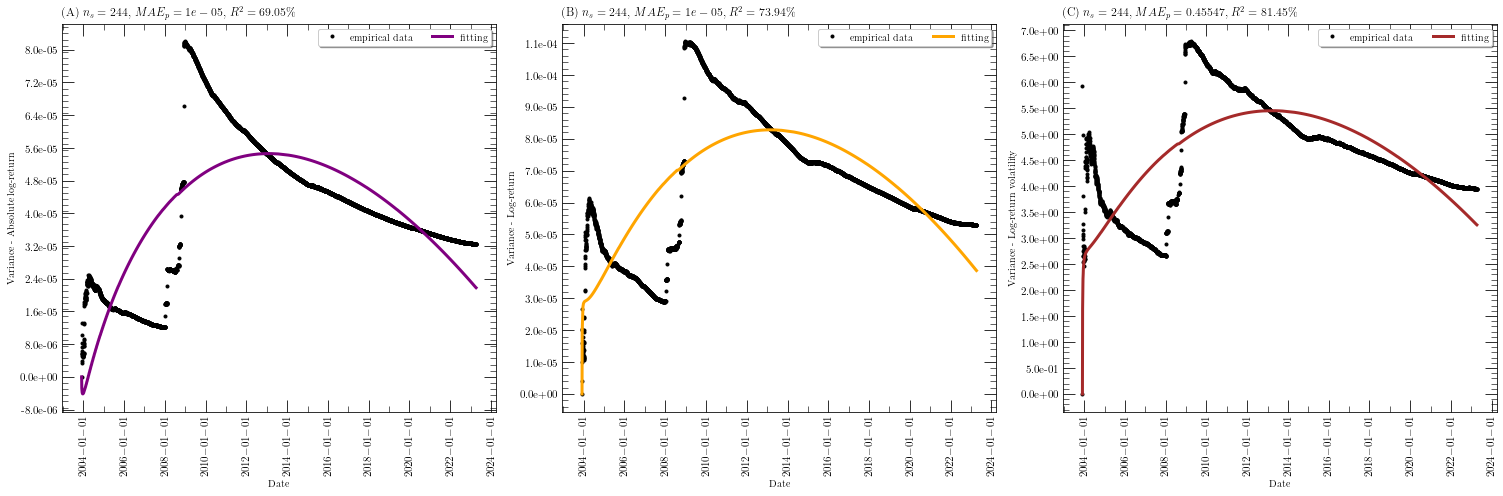

Generated plot for SGD=X and time series absolute log-return
Generated plot for SGD=X and time series log-return
Generated plot for SGD=X and time series log-return volatility


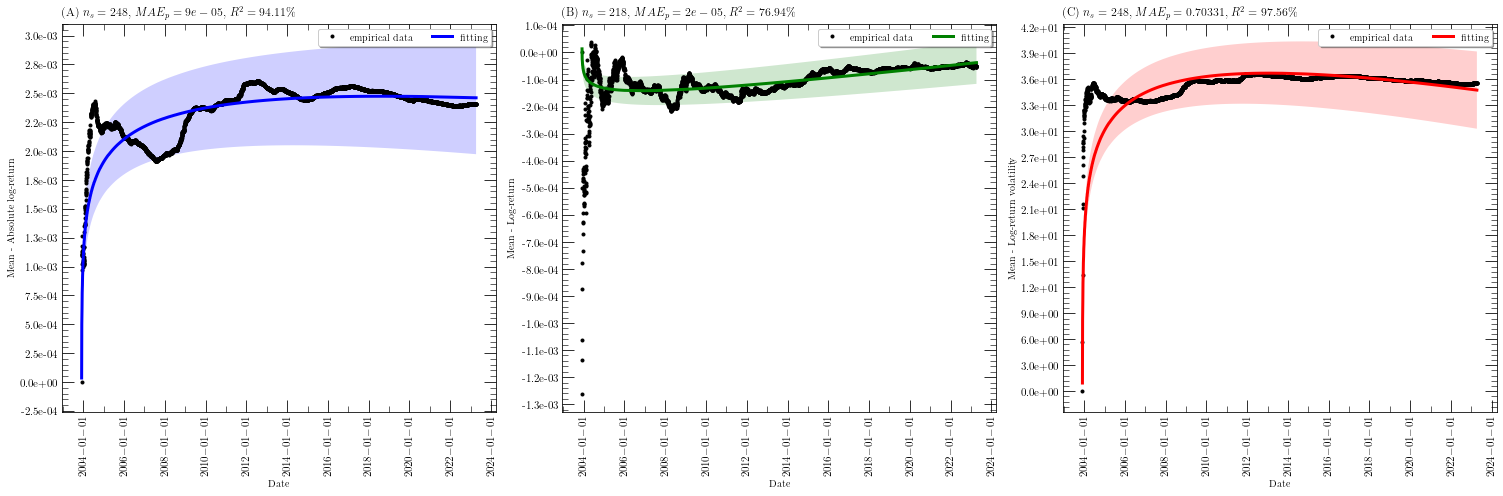

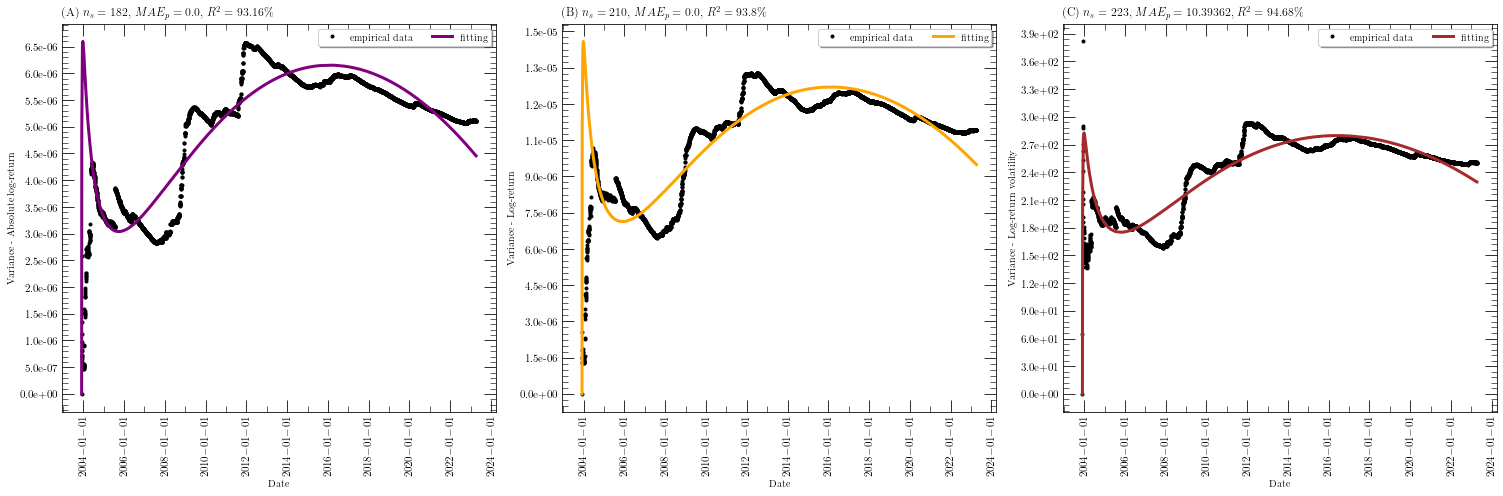

Generated plot for CAD=X and time series absolute log-return
Generated plot for CAD=X and time series log-return
Generated plot for CAD=X and time series log-return volatility


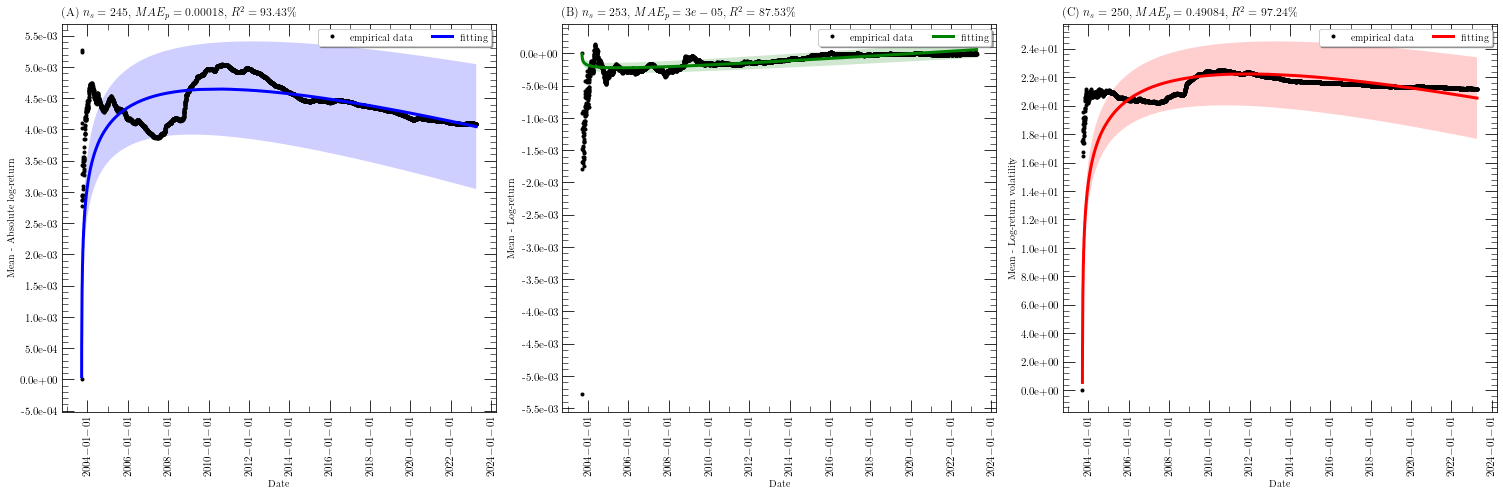

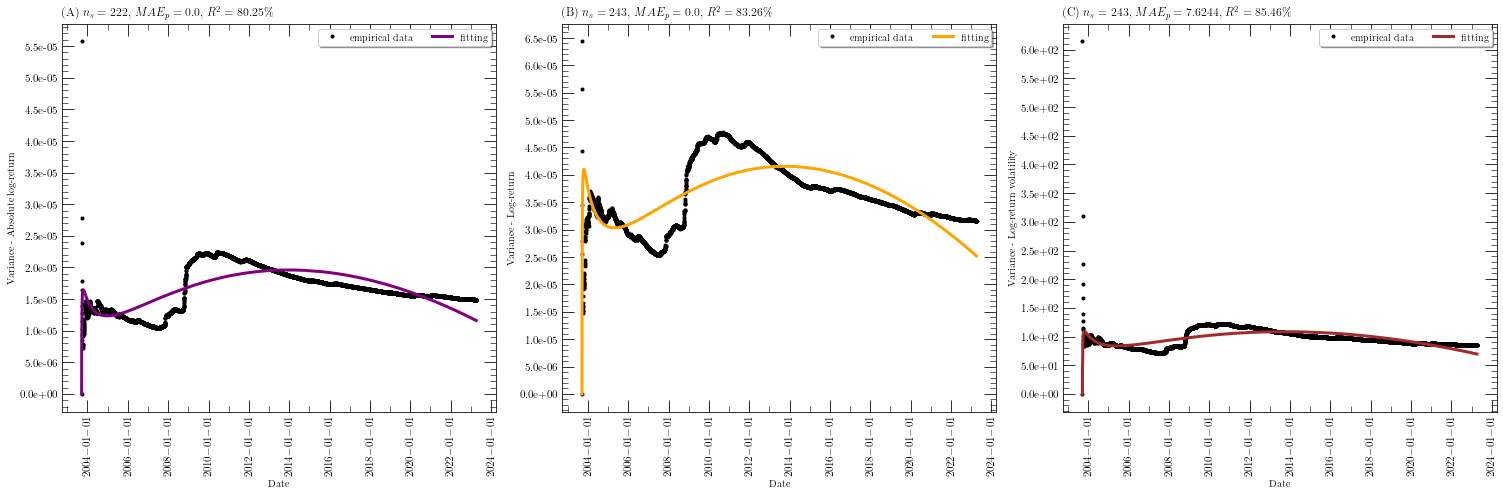

Generated plot for AUD=X and time series absolute log-return
Generated plot for AUD=X and time series log-return
Generated plot for AUD=X and time series log-return volatility


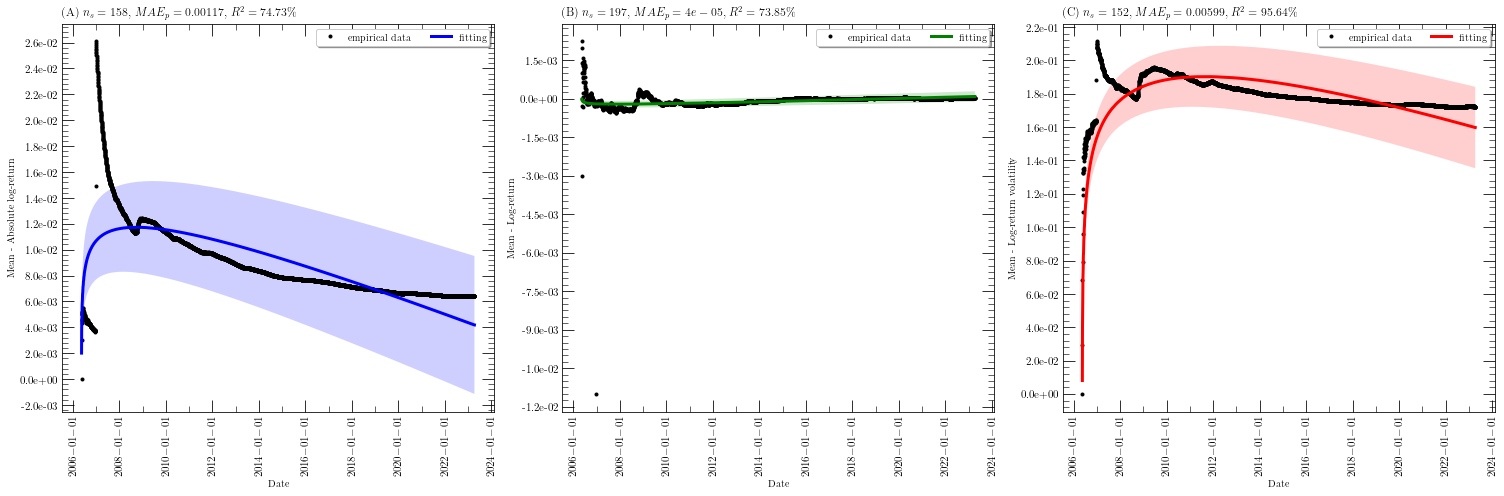

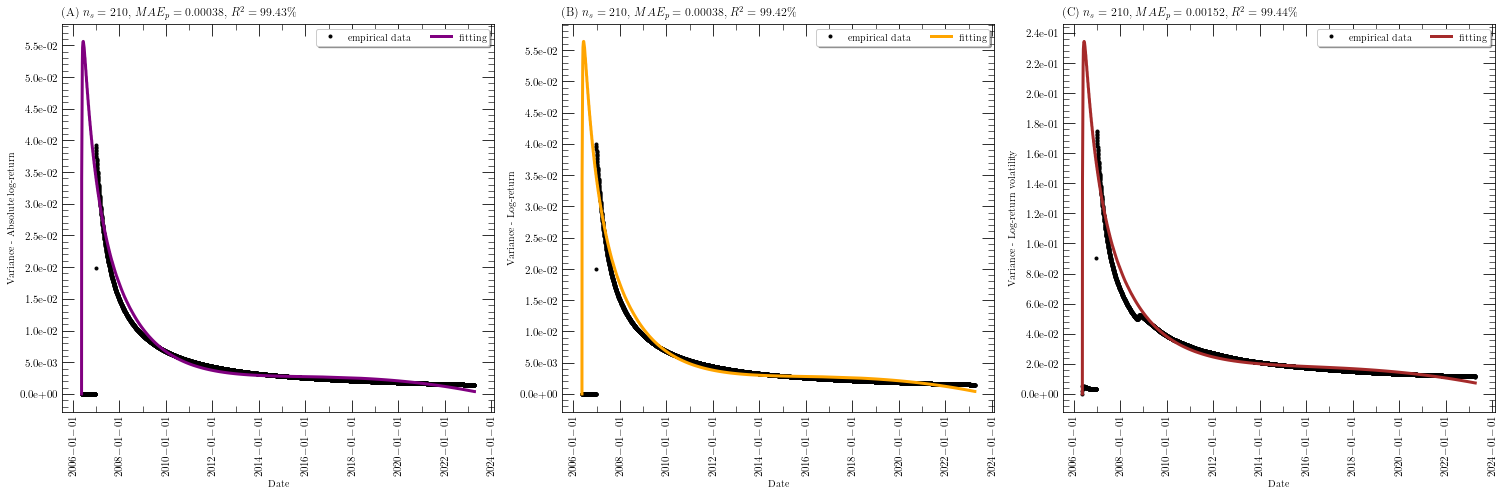

Generated plot for NZD=X and time series absolute log-return
Generated plot for NZD=X and time series log-return
Generated plot for NZD=X and time series log-return volatility


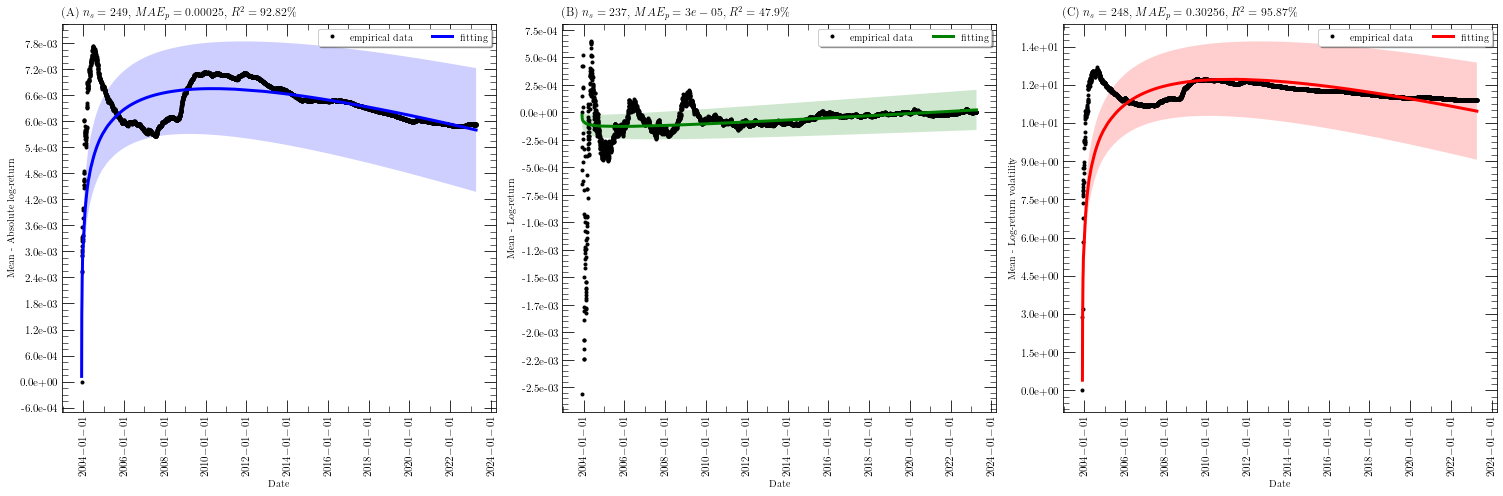

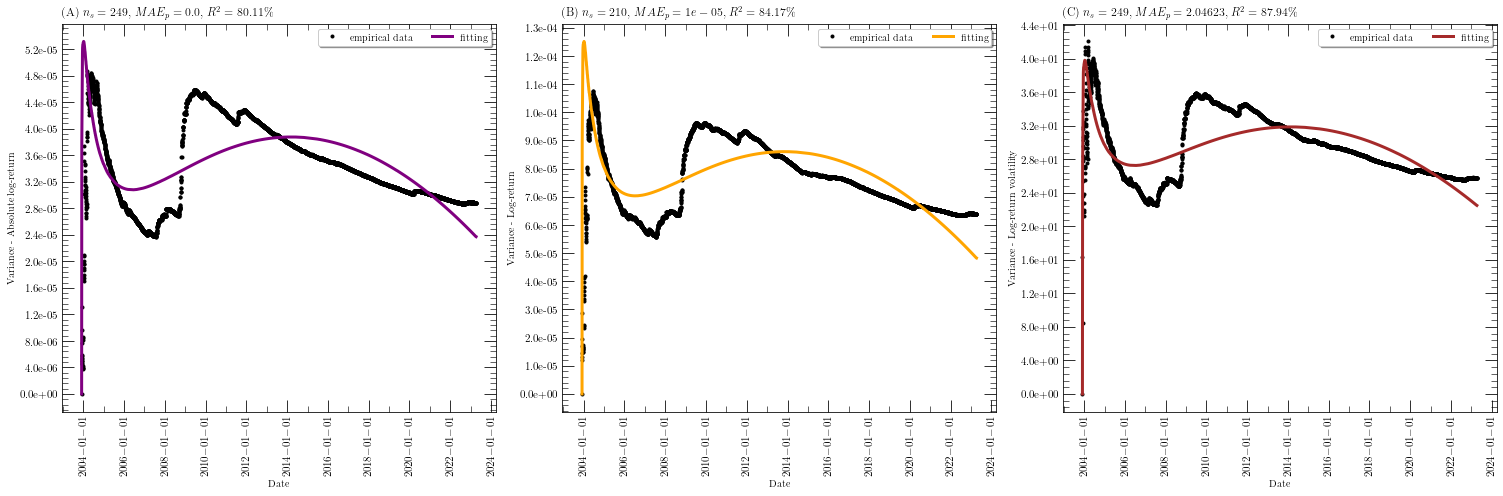

Generated plot for MYR=X and time series absolute log-return
Generated plot for MYR=X and time series log-return
Generated plot for MYR=X and time series log-return volatility


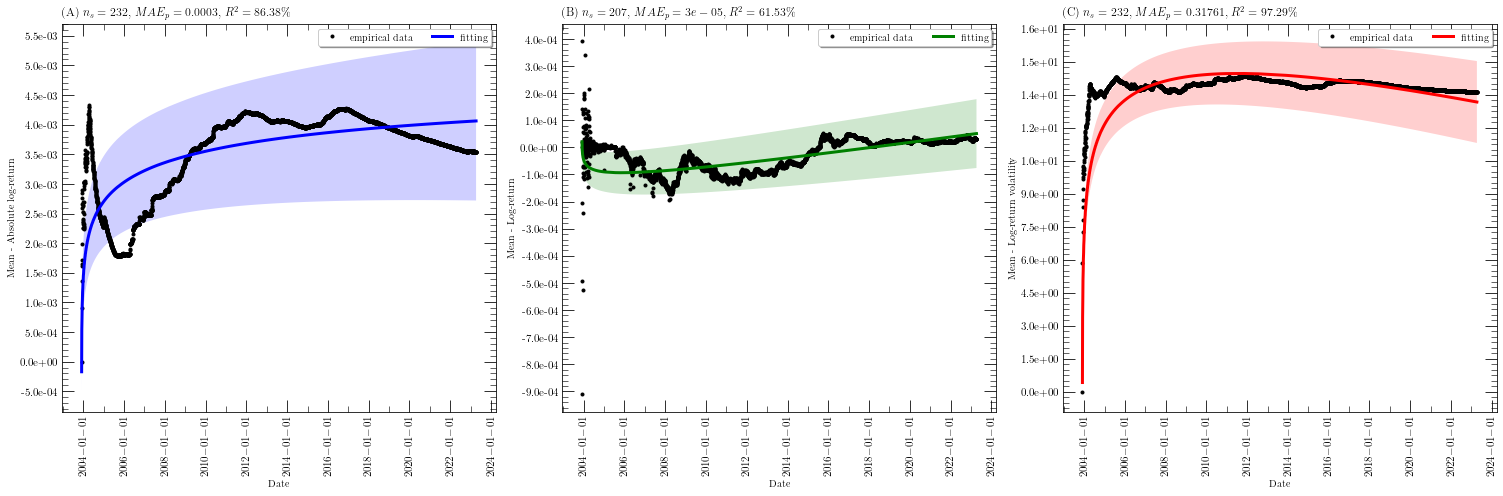

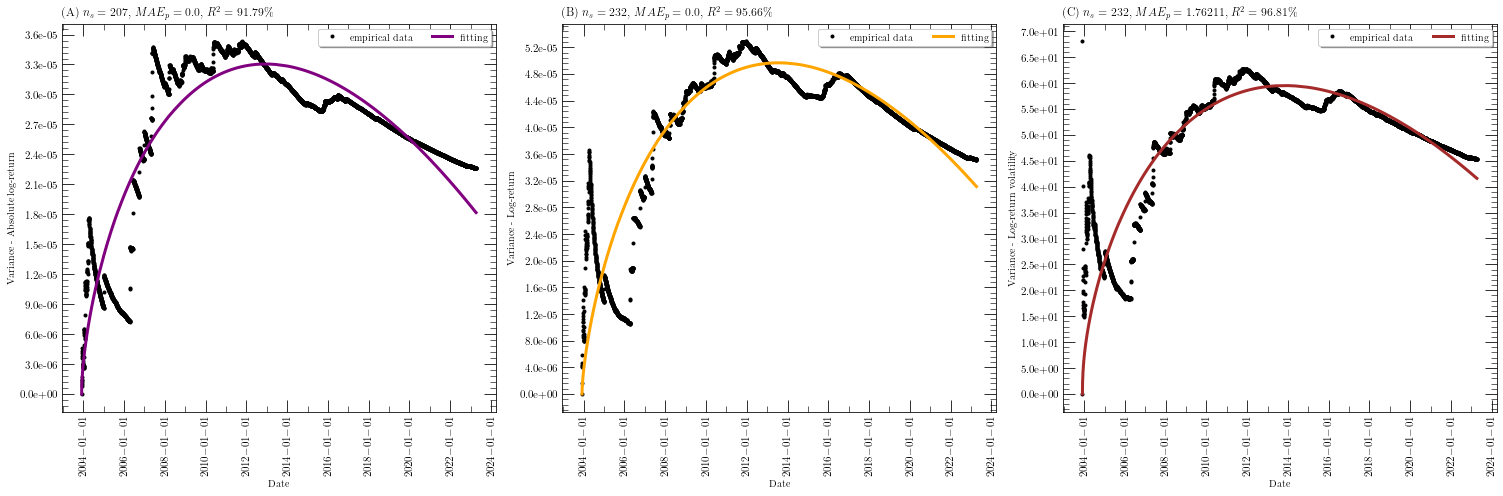

Generated plot for BRL=X and time series absolute log-return
Generated plot for BRL=X and time series log-return
Generated plot for BRL=X and time series log-return volatility


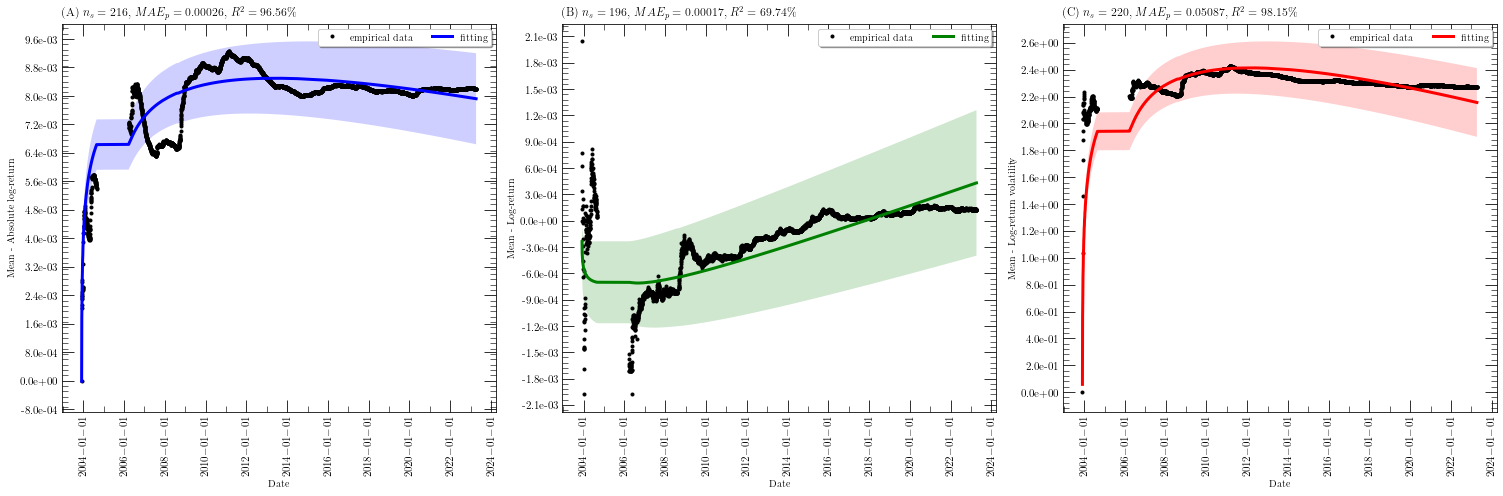

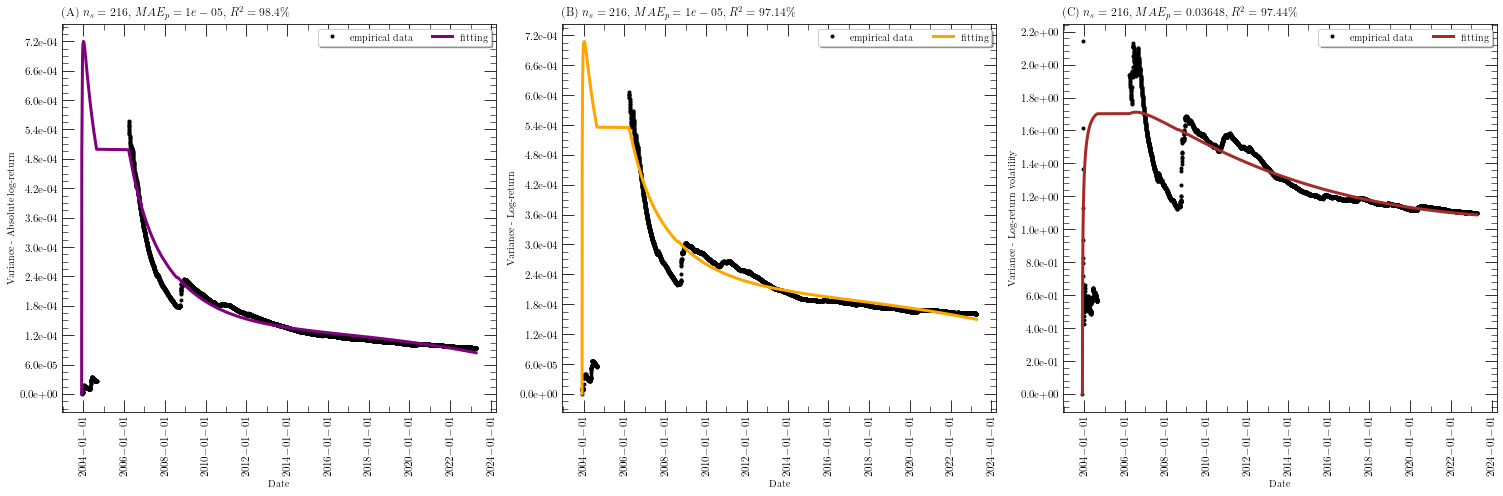

Generated plot for CNY=X and time series absolute log-return
Generated plot for CNY=X and time series log-return
Generated plot for CNY=X and time series log-return volatility


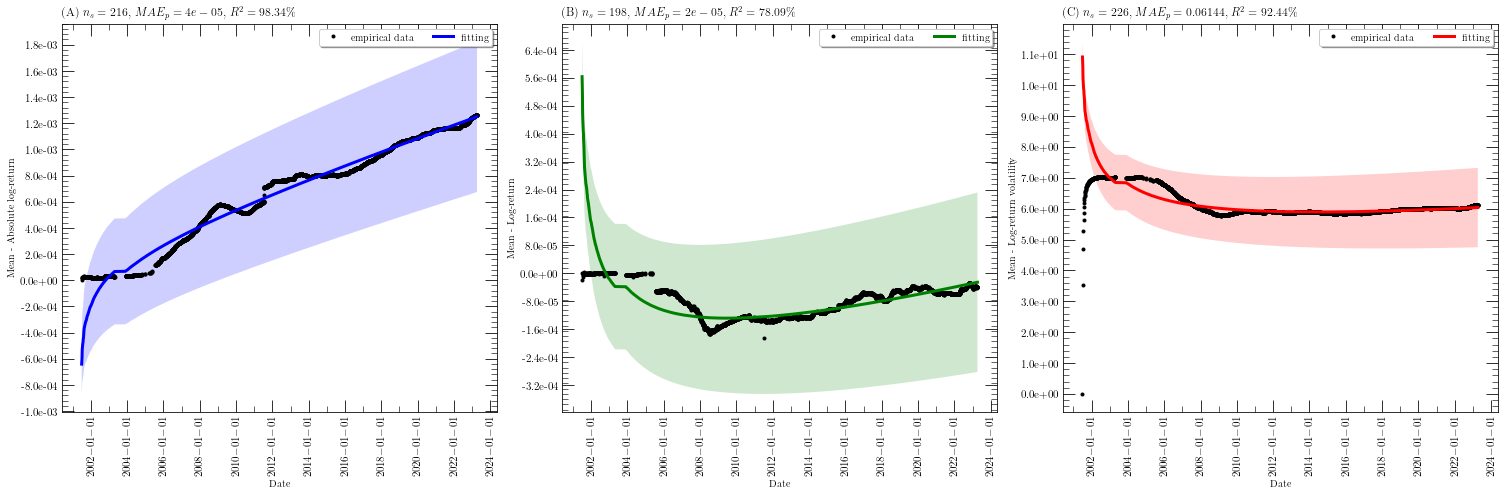

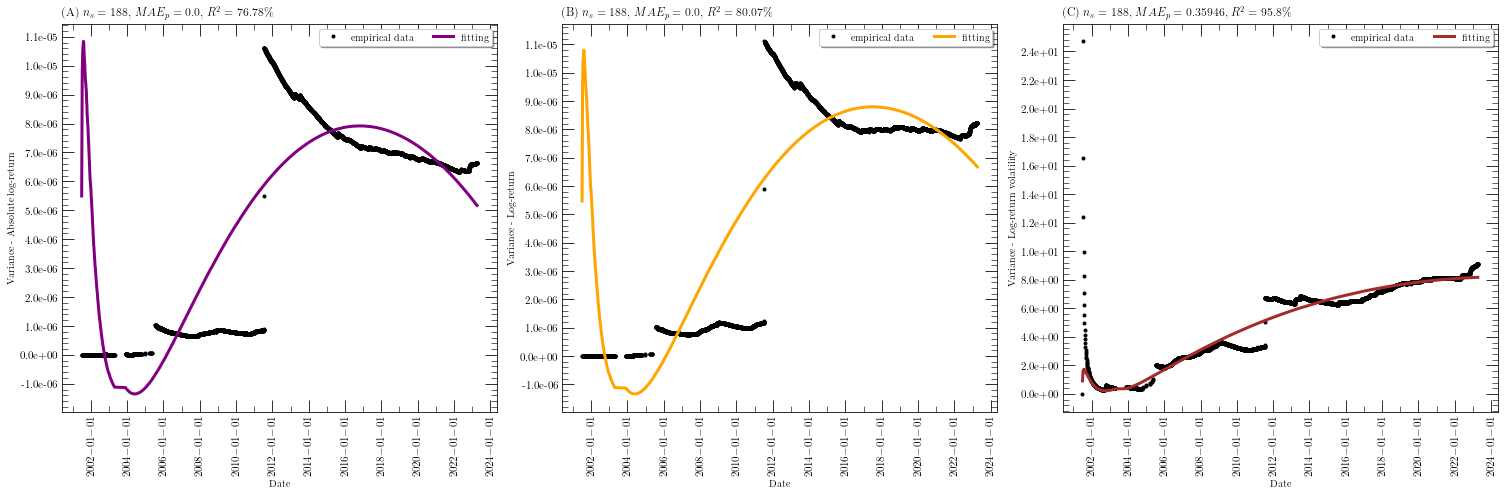

Generated plot for HKD=X and time series absolute log-return
Generated plot for HKD=X and time series log-return
Generated plot for HKD=X and time series log-return volatility


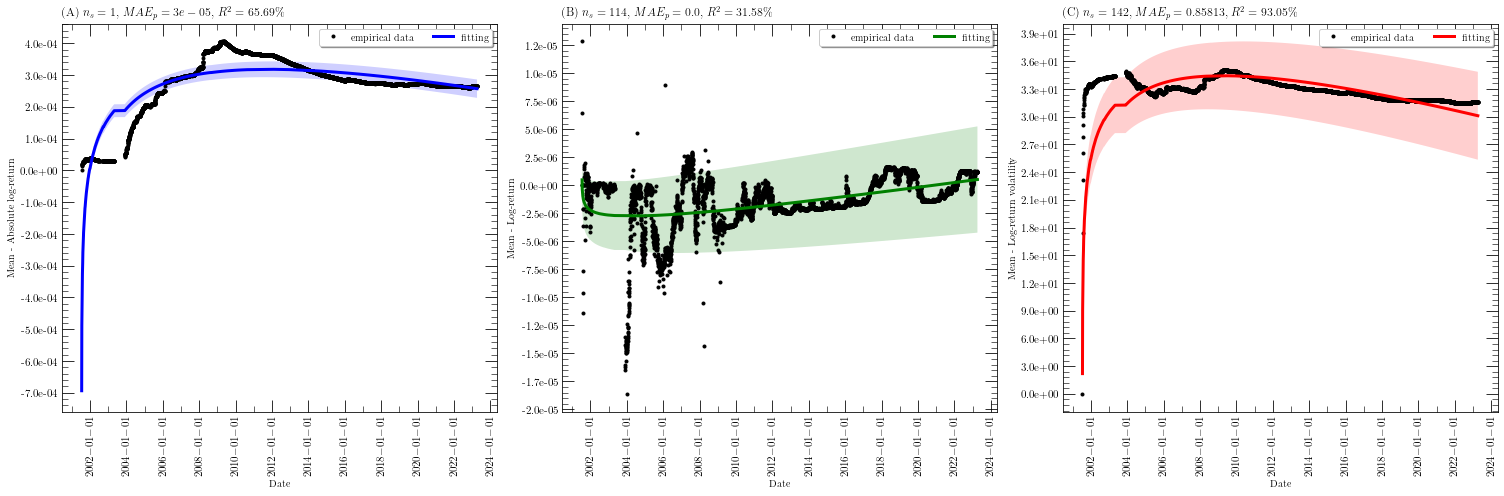

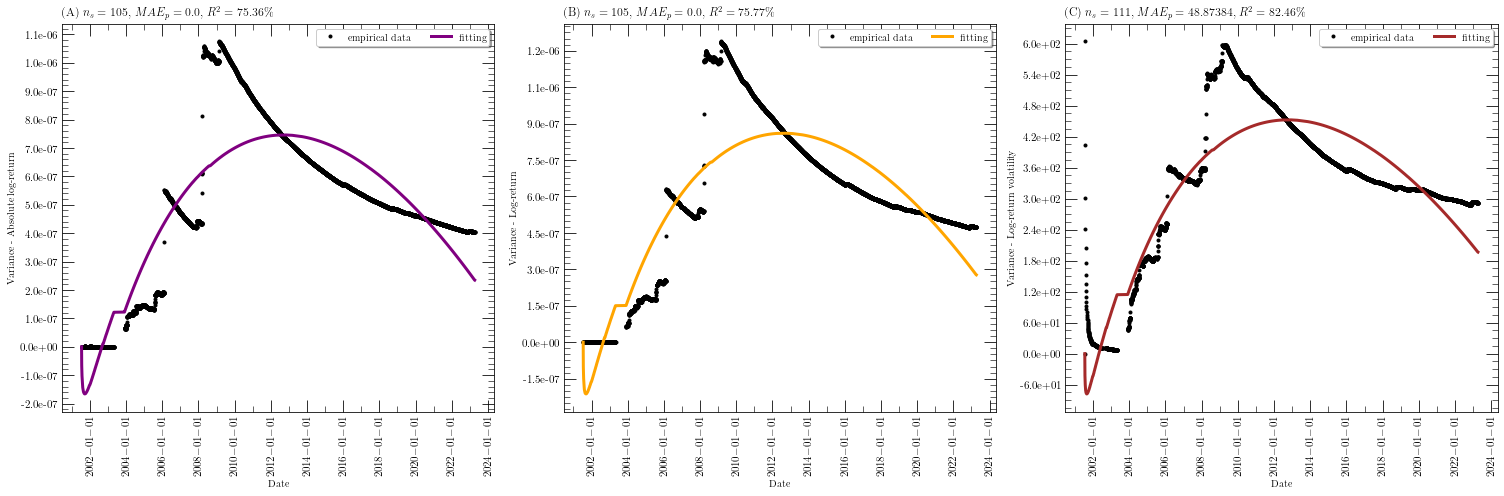

Generated plot for SEK=X and time series absolute log-return
Generated plot for SEK=X and time series log-return
Generated plot for SEK=X and time series log-return volatility


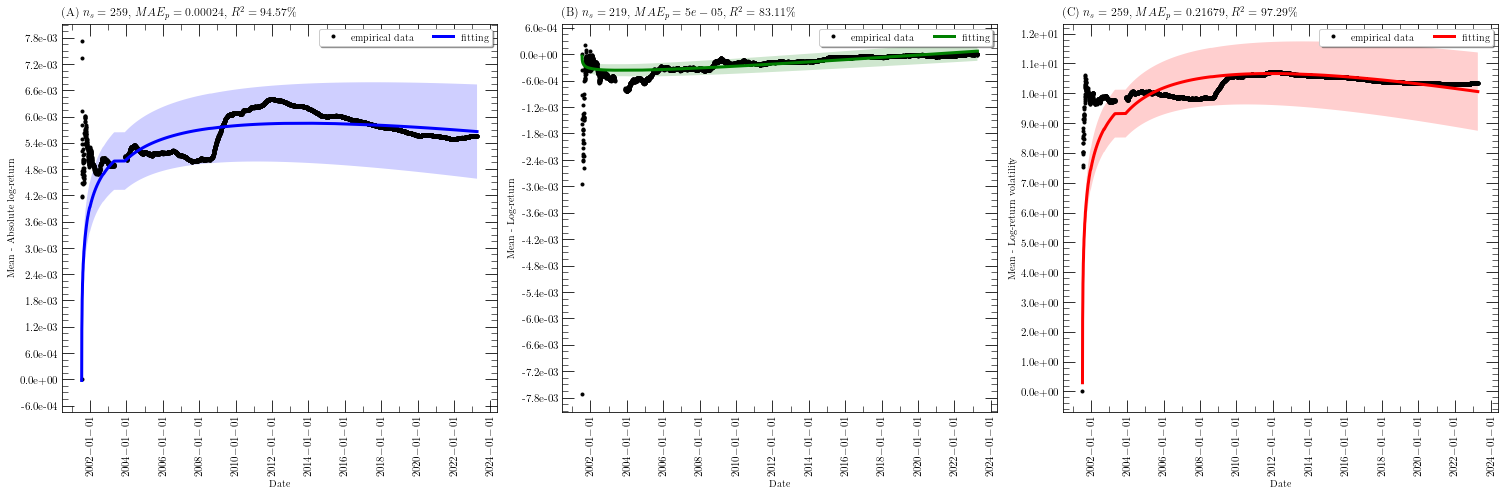

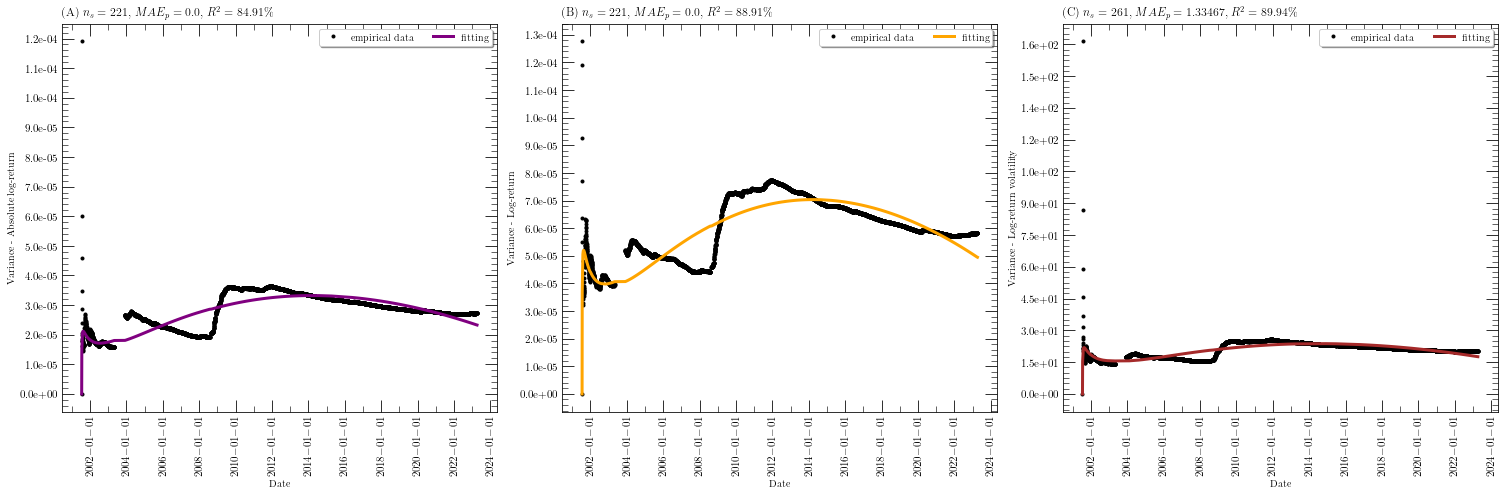

Generated plot for ZAR=X and time series absolute log-return
Generated plot for ZAR=X and time series log-return
Generated plot for ZAR=X and time series log-return volatility


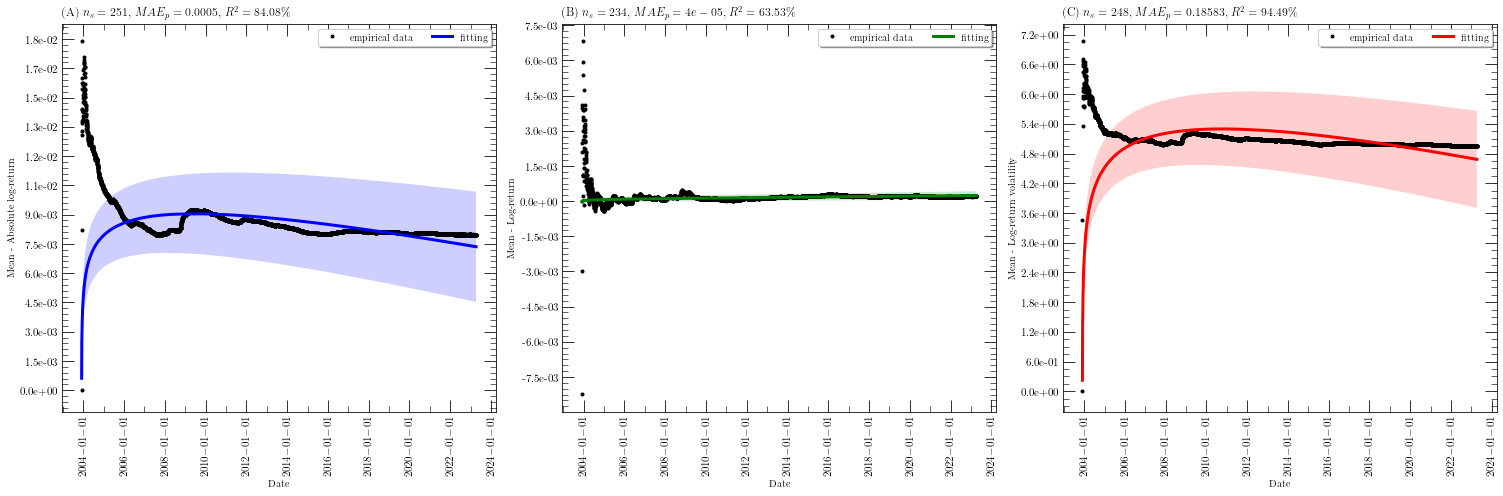

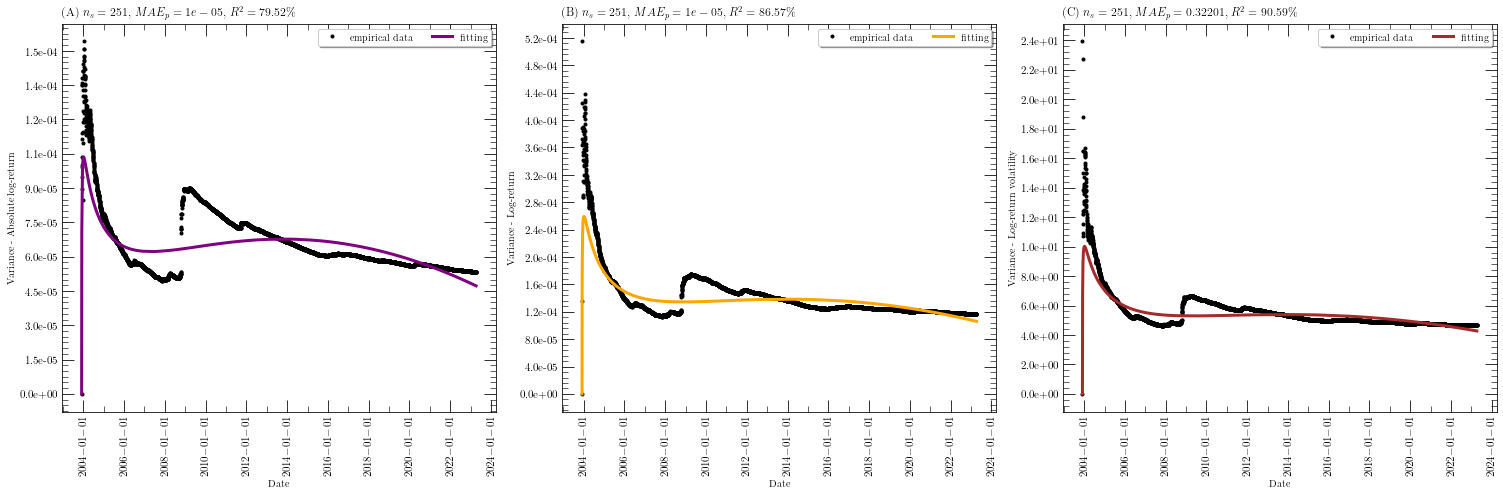

Generated plot for MXN=X and time series absolute log-return
Generated plot for MXN=X and time series log-return
Generated plot for MXN=X and time series log-return volatility


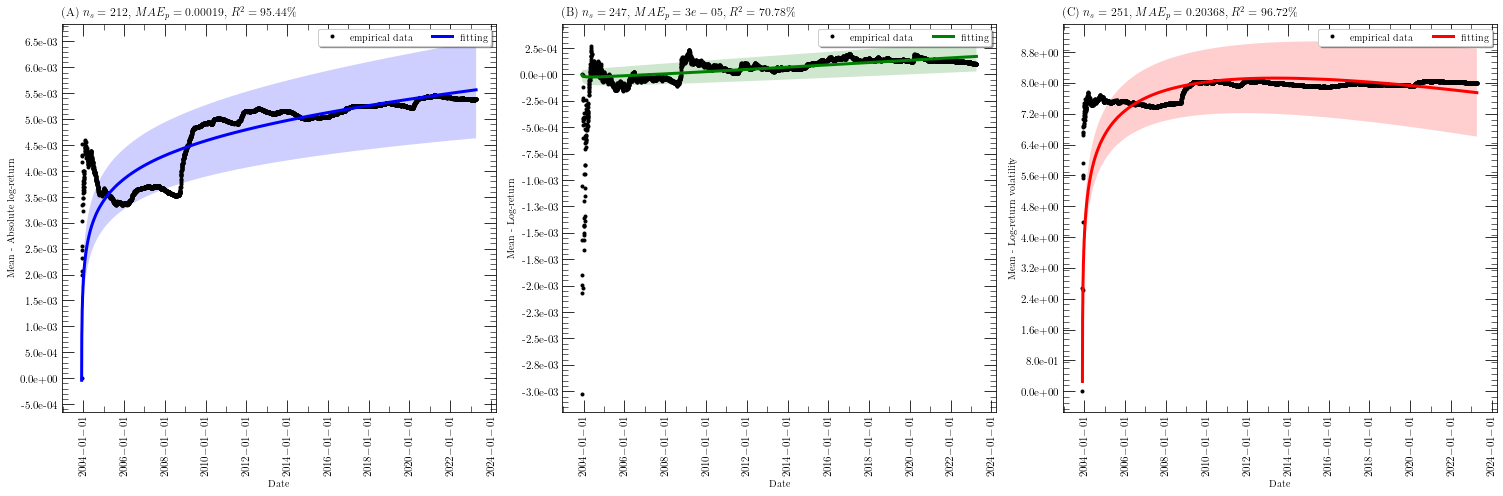

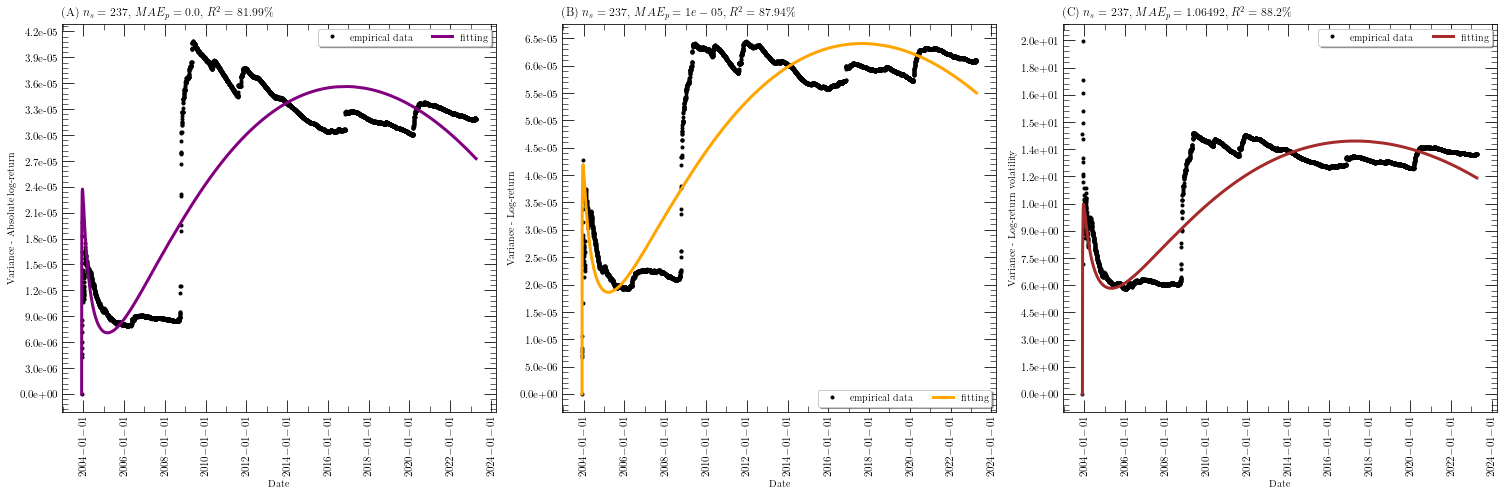

Generated plot for THB=X and time series absolute log-return
Generated plot for THB=X and time series log-return
Generated plot for THB=X and time series log-return volatility


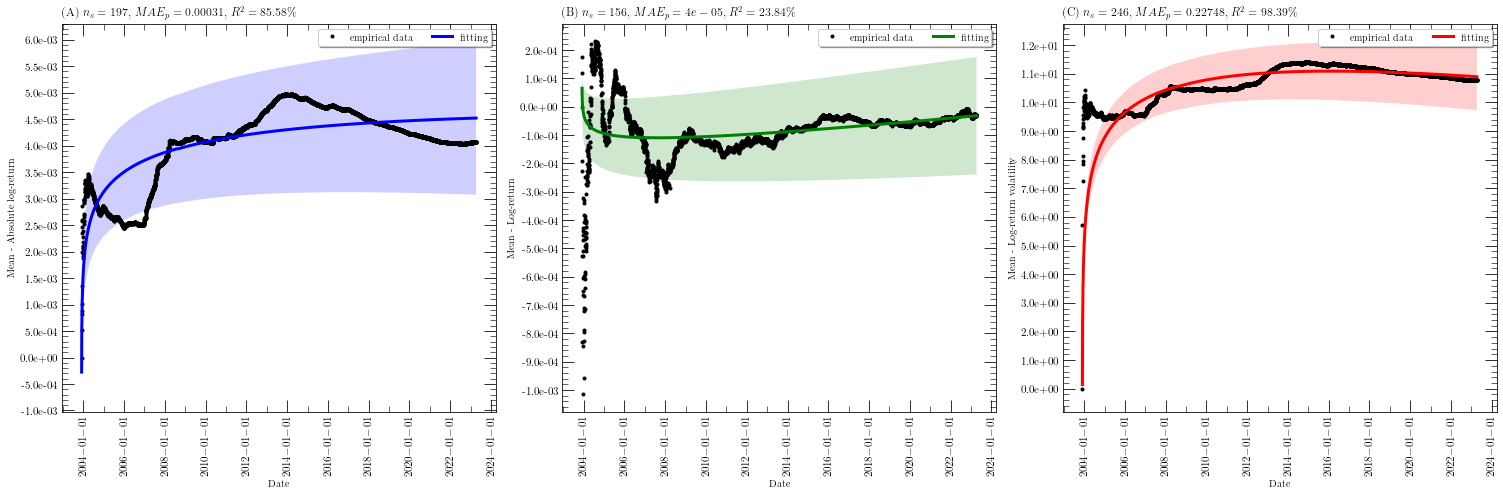

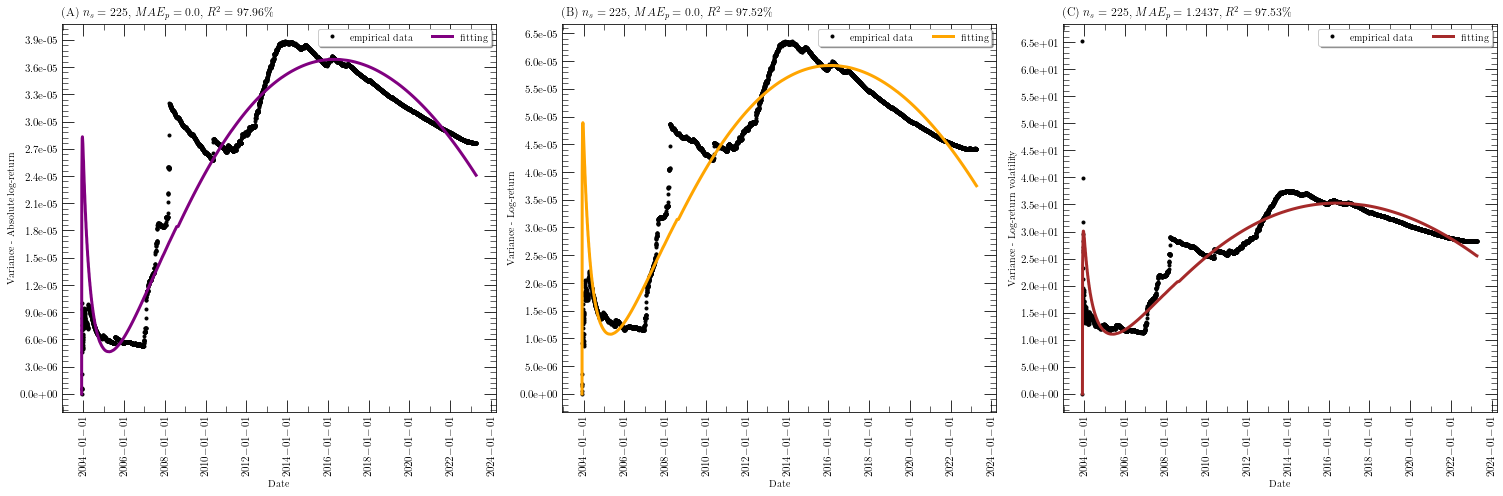

Generated plot for PHP=X and time series absolute log-return
Generated plot for PHP=X and time series log-return
Generated plot for PHP=X and time series log-return volatility


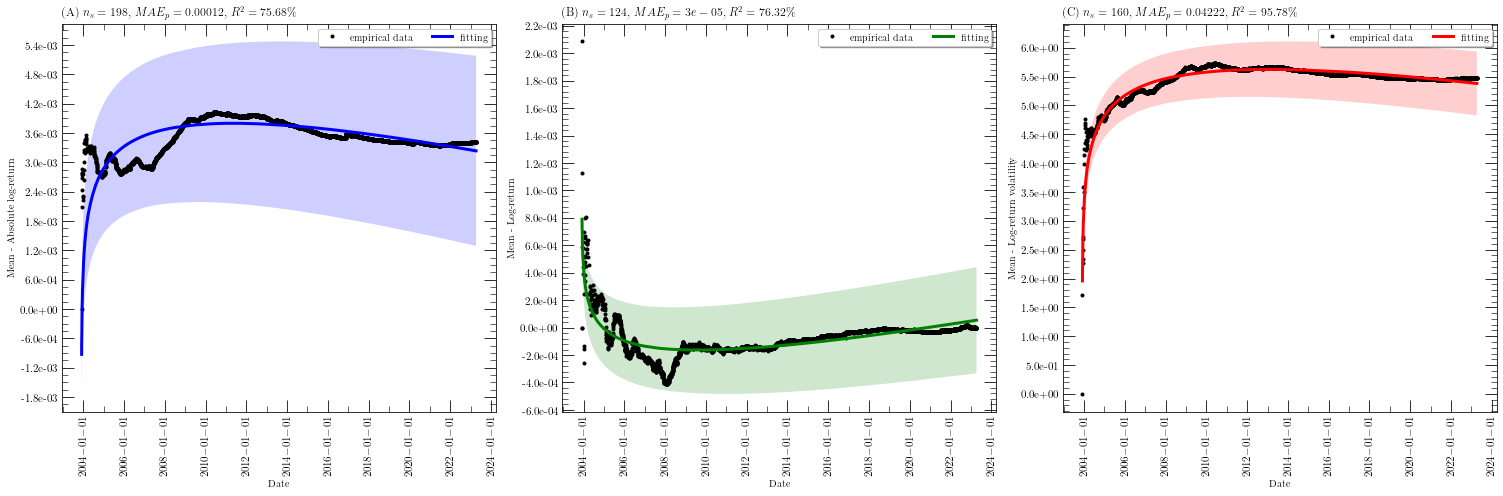

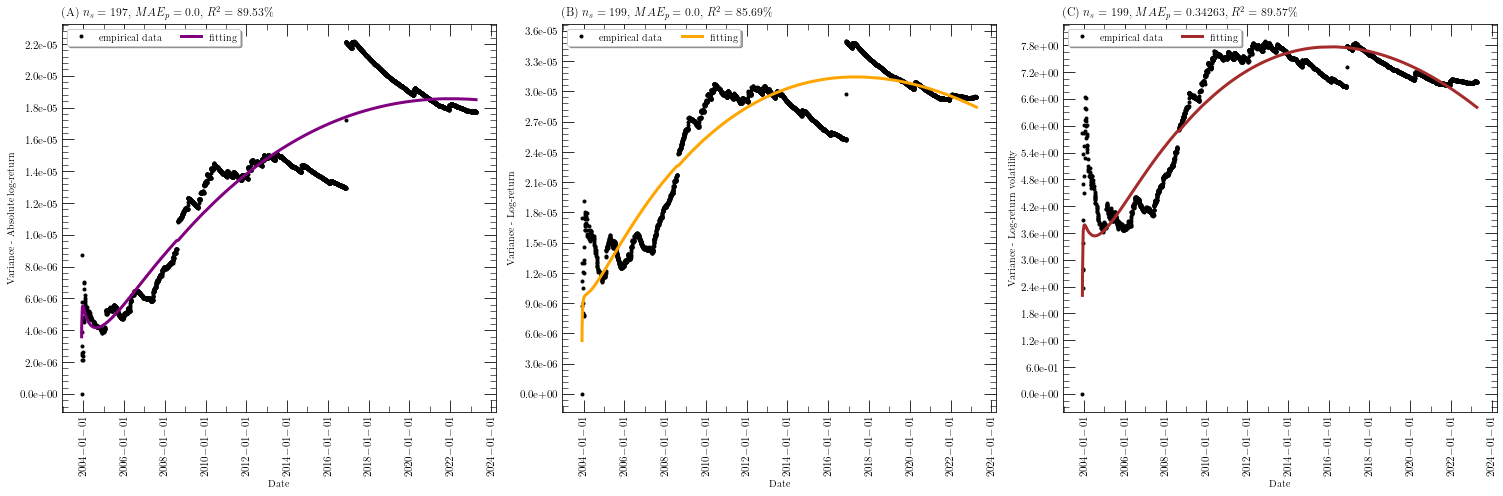

Generated plot for RUB=X and time series absolute log-return
Generated plot for RUB=X and time series log-return
Generated plot for RUB=X and time series log-return volatility


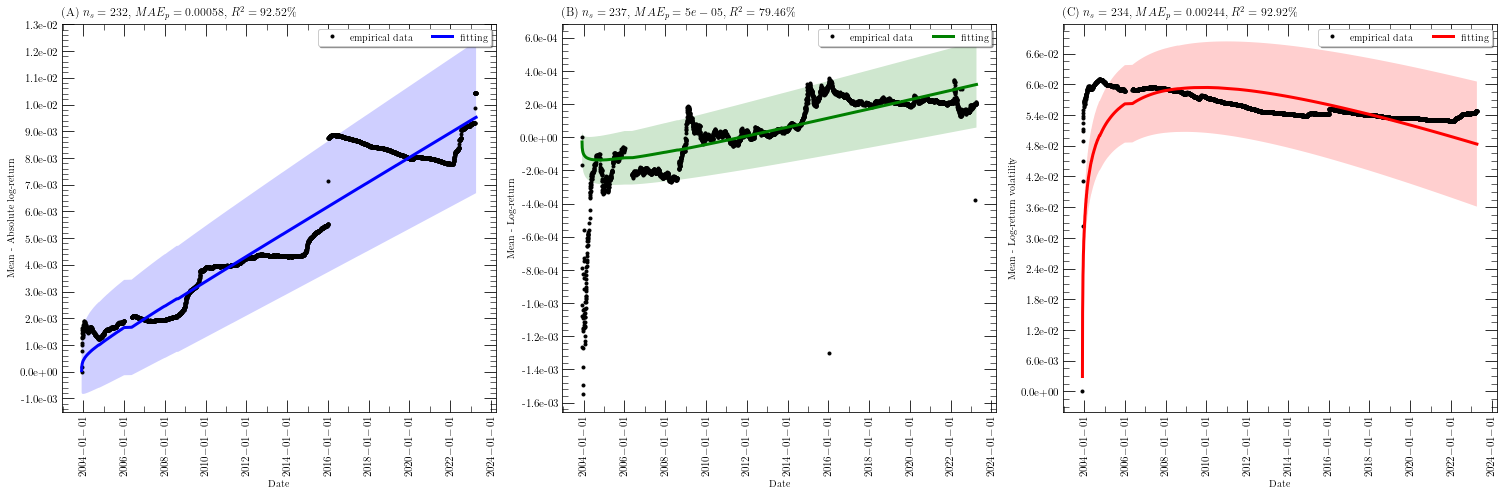

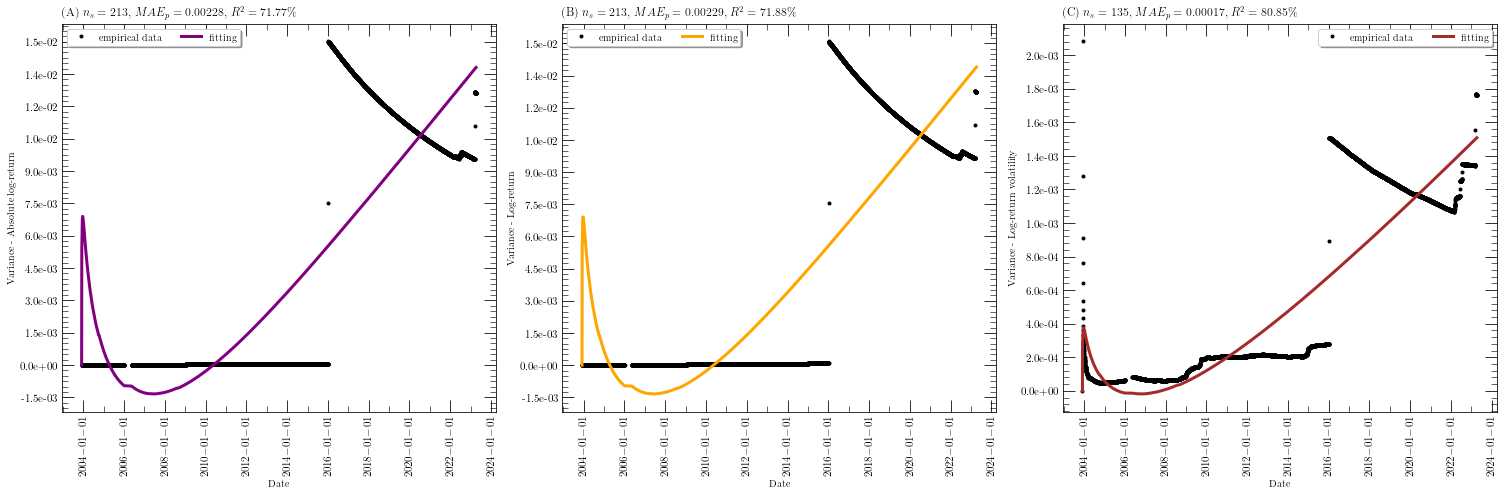

Generated plot for INR=X and time series absolute log-return
Generated plot for INR=X and time series log-return
Generated plot for INR=X and time series log-return volatility


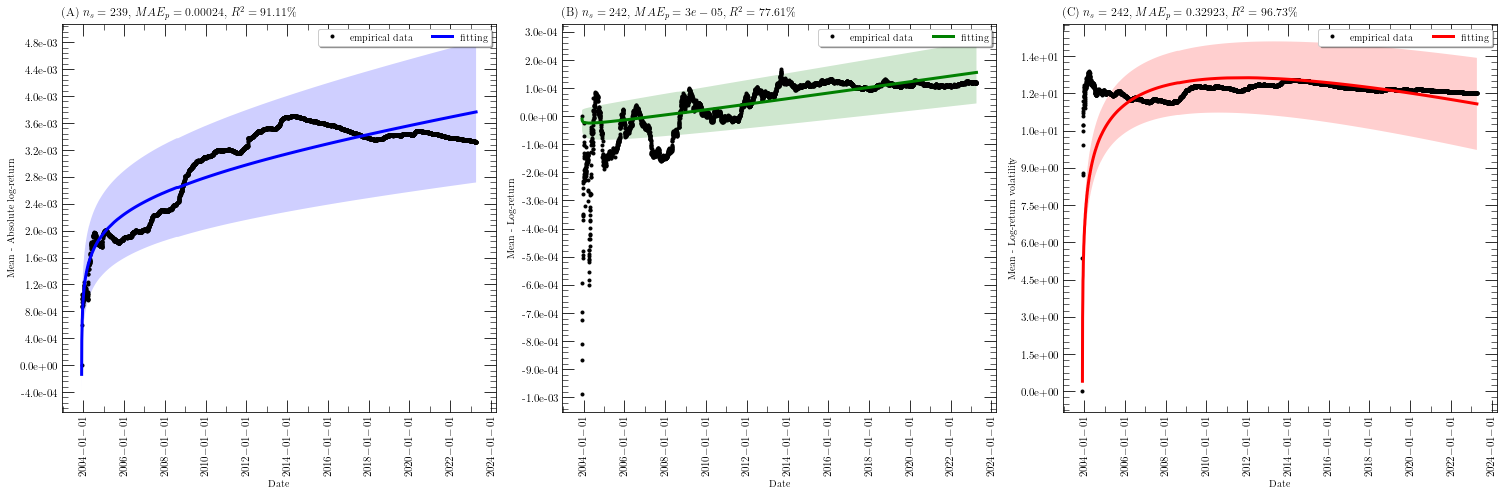

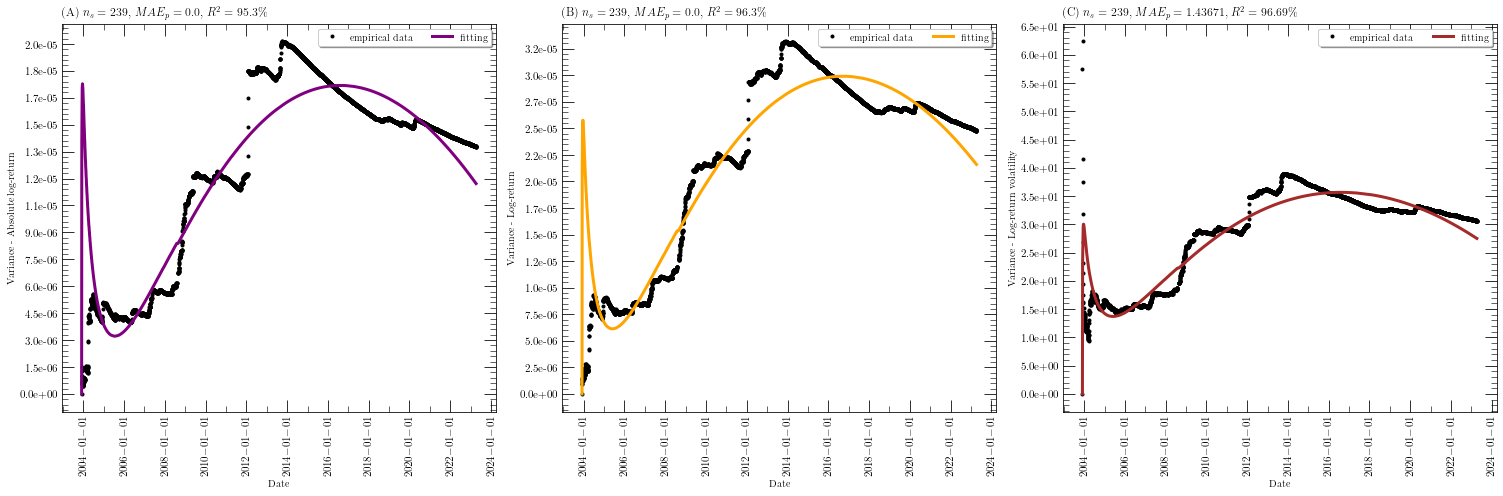

Generated plot for JPY=X and time series absolute log-return
Generated plot for JPY=X and time series log-return
Generated plot for JPY=X and time series log-return volatility


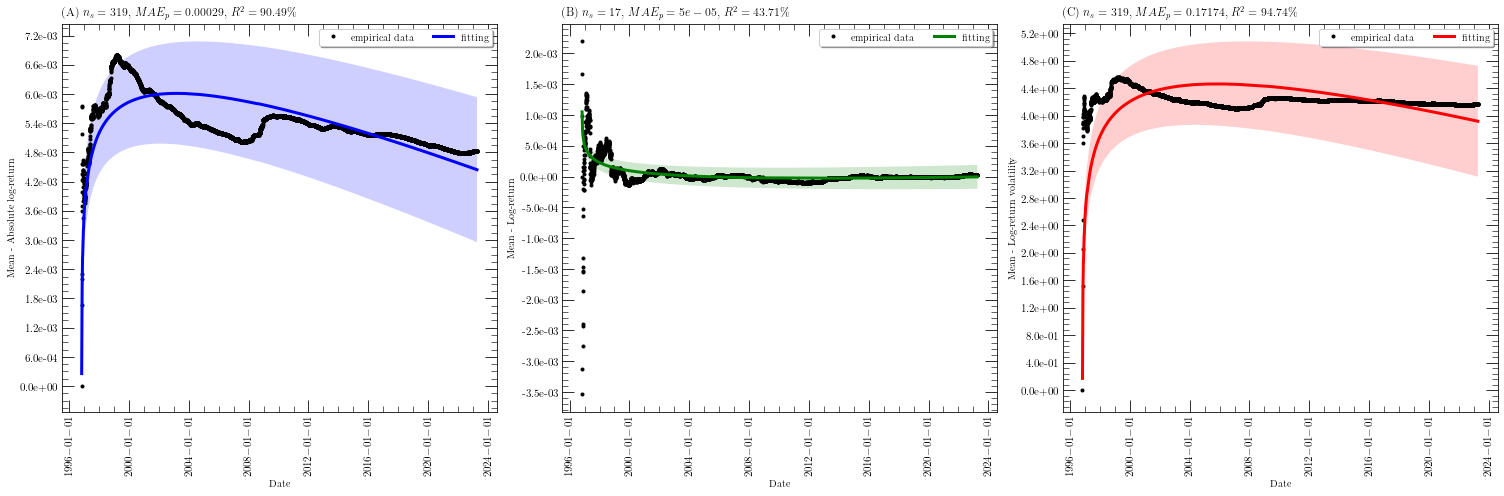

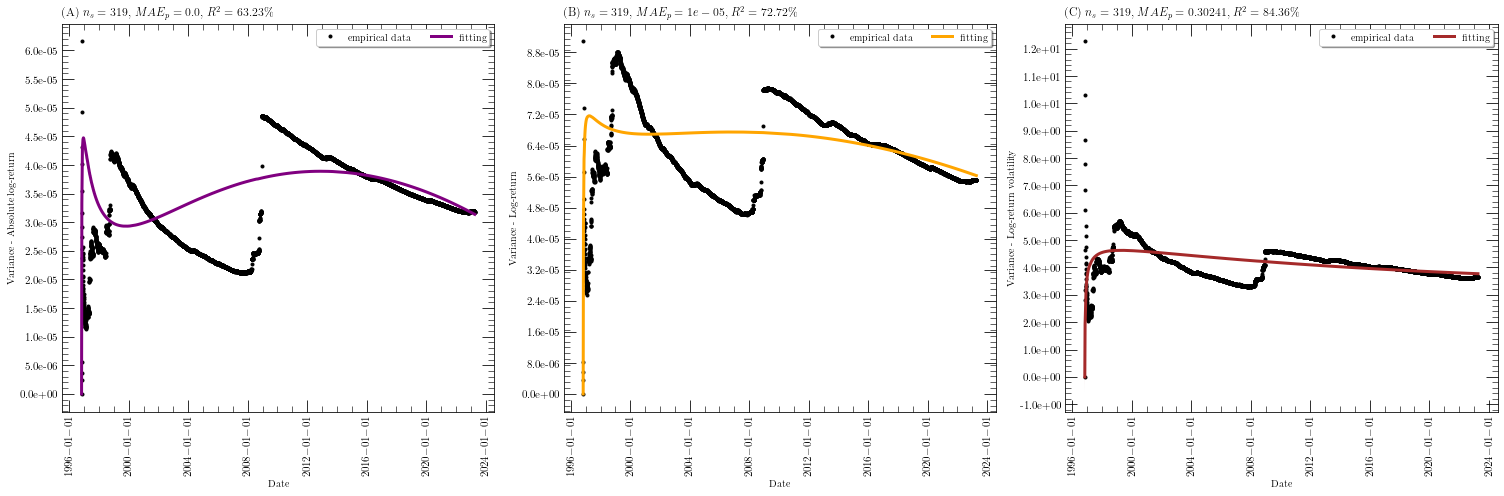

Generated plot for HUF=X and time series absolute log-return
Generated plot for HUF=X and time series log-return
Generated plot for HUF=X and time series log-return volatility


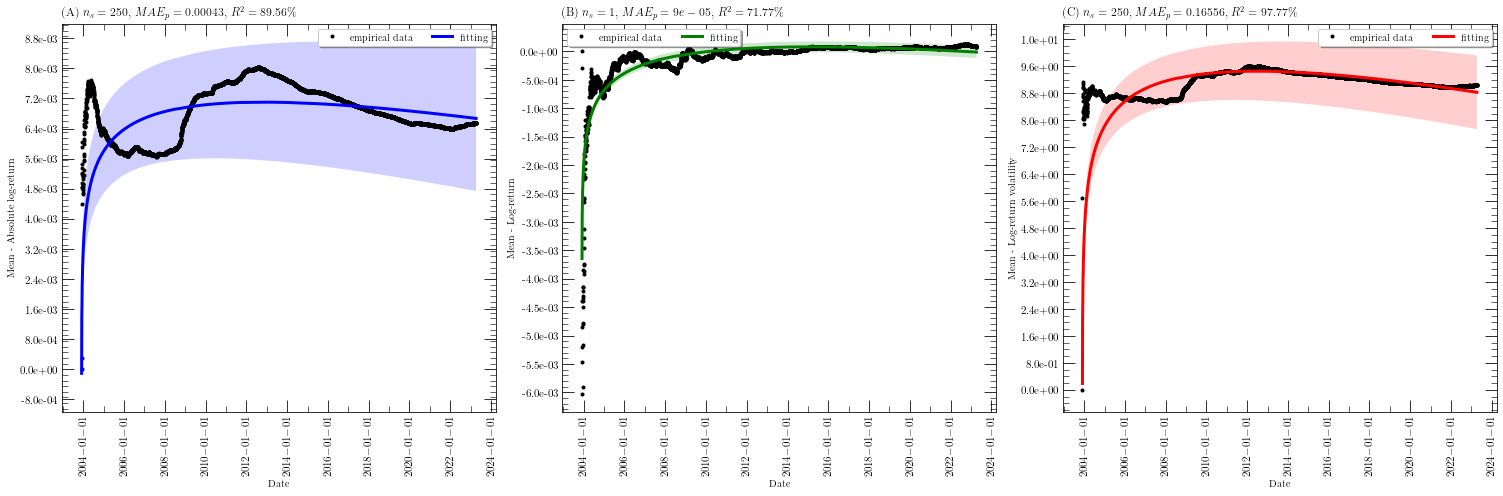

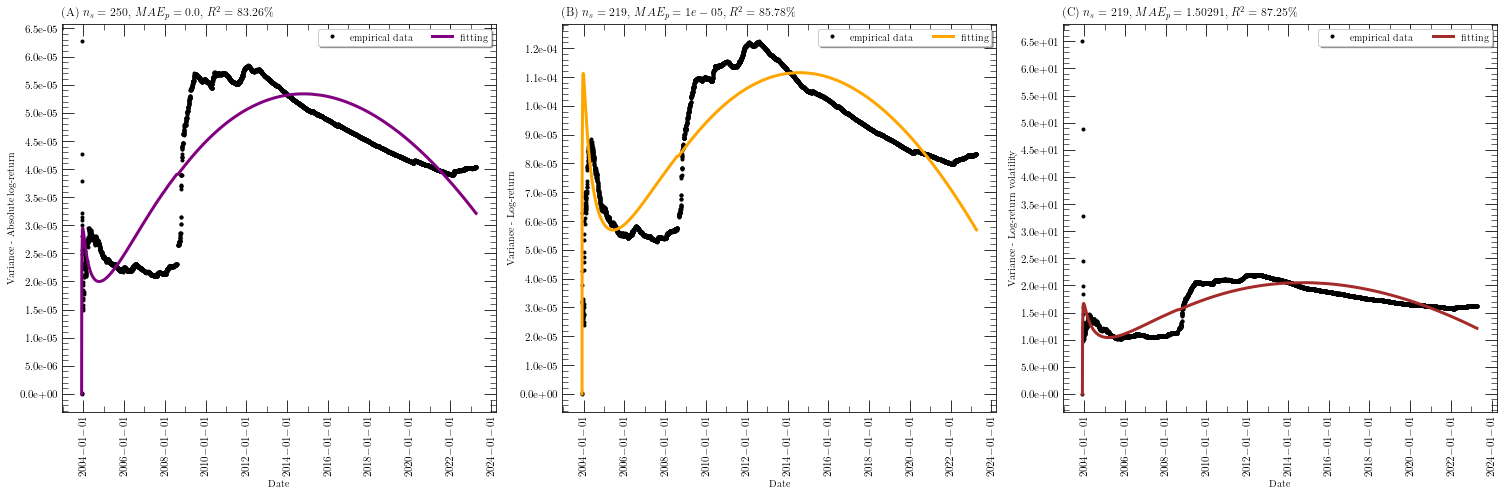

Generated plot for COP=X and time series absolute log-return
Generated plot for COP=X and time series log-return
Generated plot for COP=X and time series log-return volatility


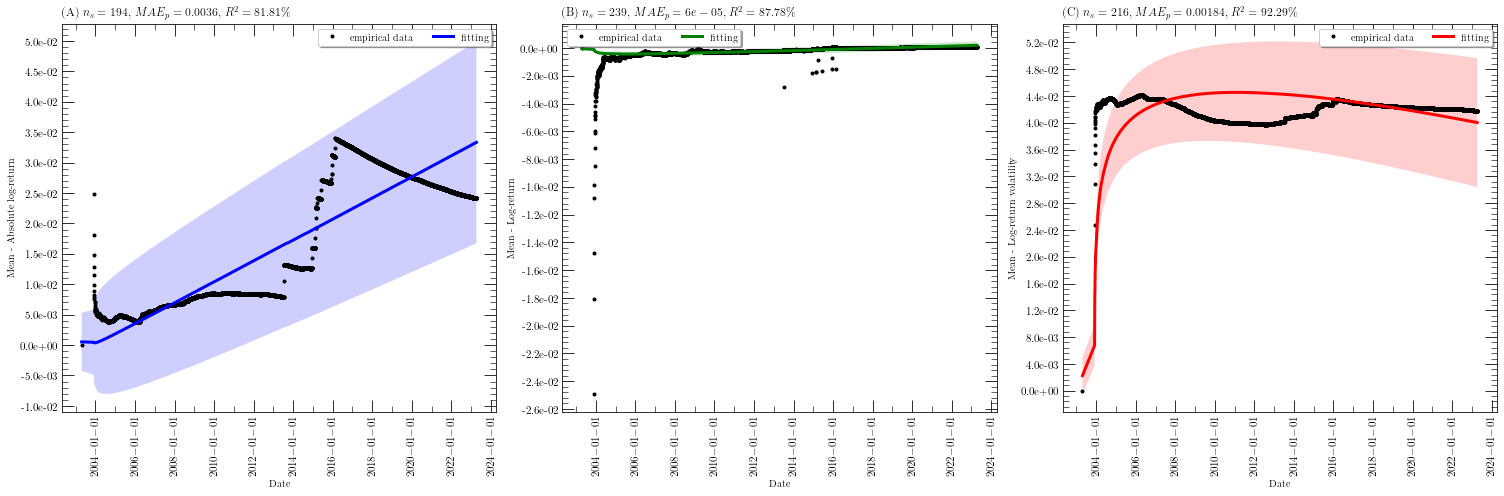

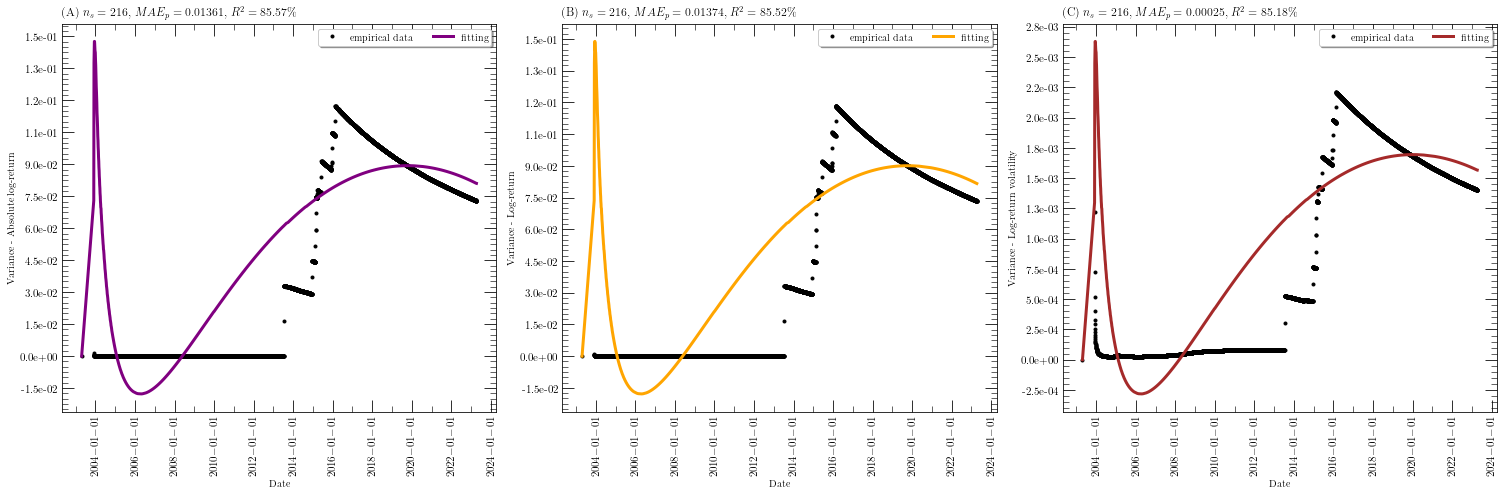

Generated plot for IDR=X and time series absolute log-return
Generated plot for IDR=X and time series log-return
Generated plot for IDR=X and time series log-return volatility


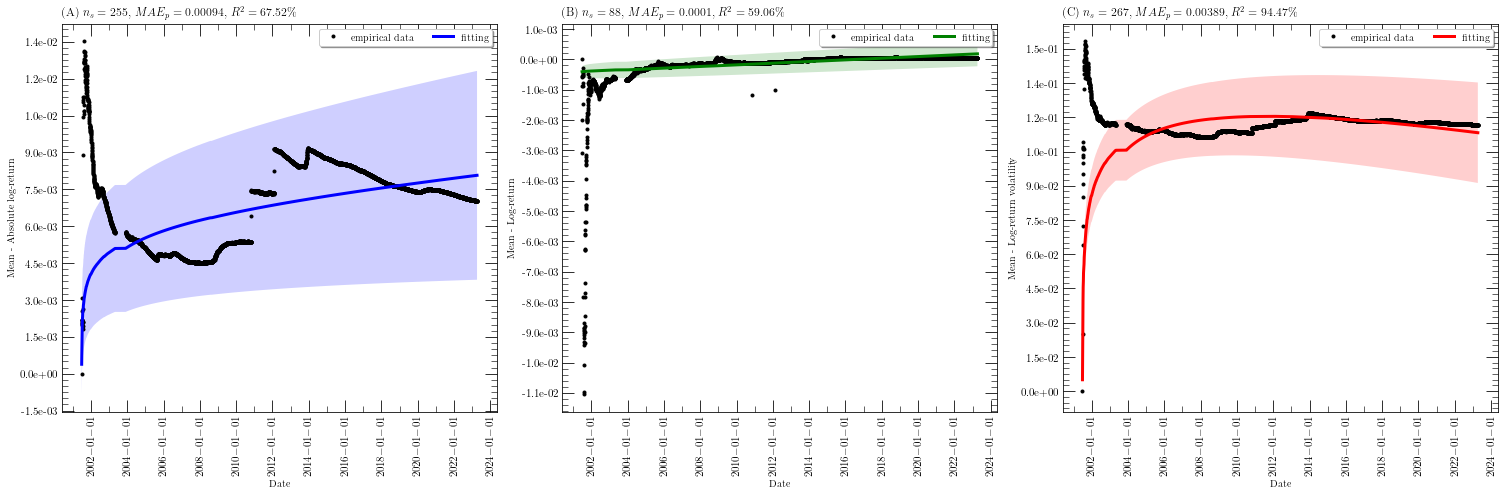

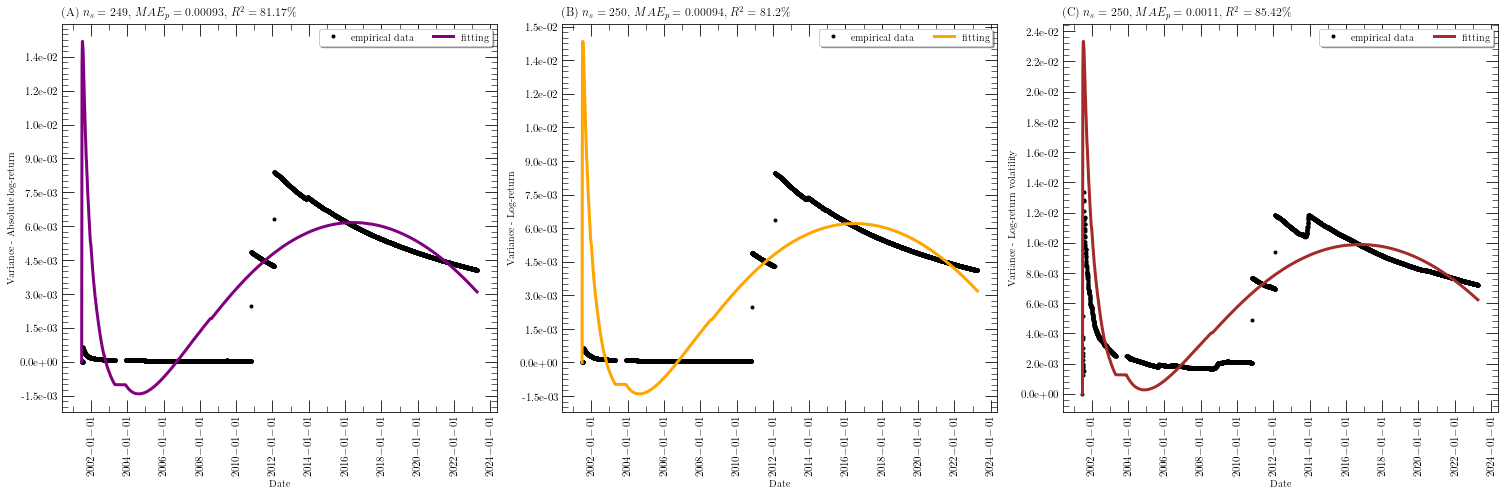

Generated plot for EURCOP=X and time series absolute log-return
Generated plot for EURCOP=X and time series log-return
Generated plot for EURCOP=X and time series log-return volatility


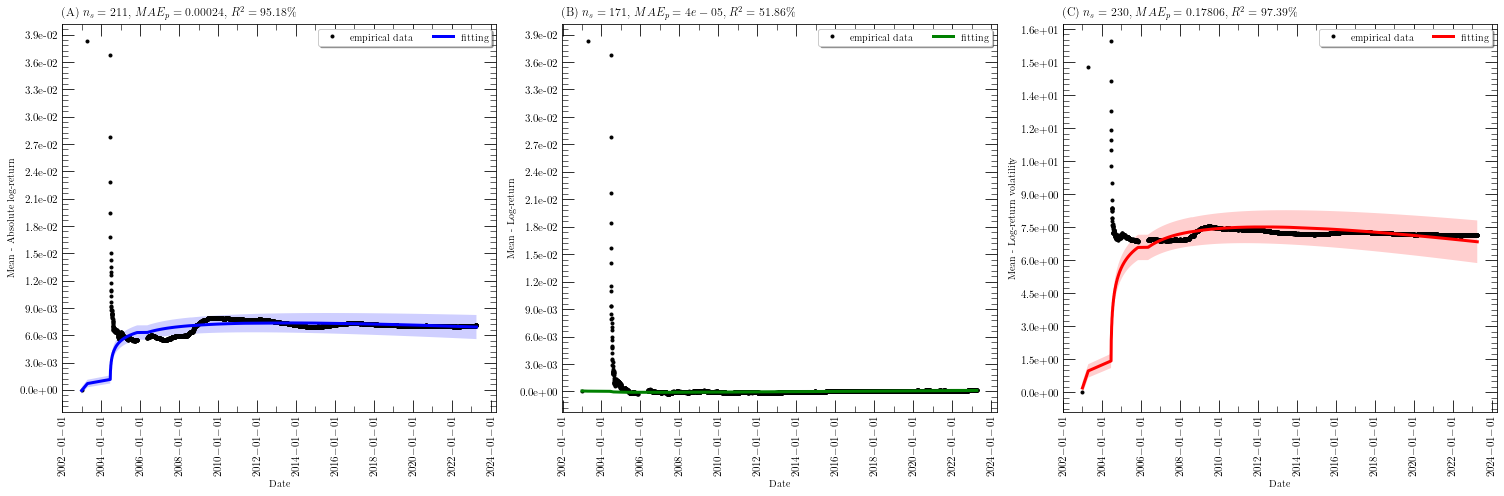

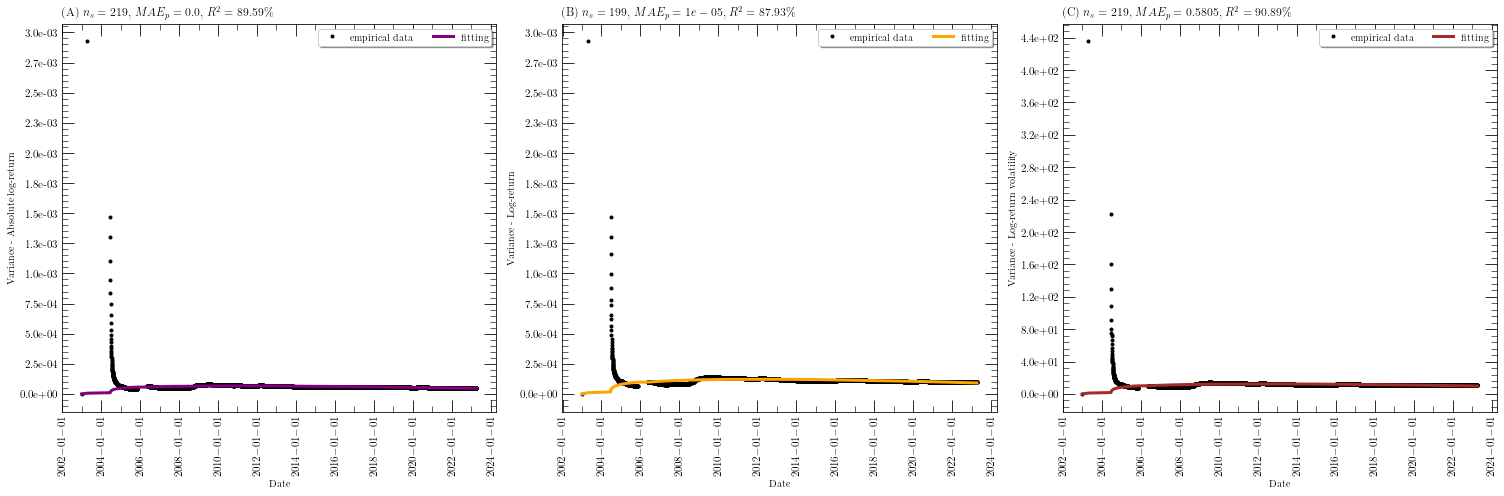

In [12]:
for ticker, ticker_name in list_currencies.items():
    df_graph = plt_ow.plot_optimal_window(
        df_fts = df_currencies,
        df_optimal = df_optimal_currencies,
        interval = "days",
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 11,
        fontsize_legend = 10,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 15,
        n_y_breaks = 15,
        fancy_legend = True,
        dpi = 200,
        save_figures = True,
        output_path = "{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = re.sub("(\^)|(=X)", "", ticker),
        input_generation_date = input_generation_date
    )